# Plot Graphs:

### Authors : Daniel (UFRN), Vicente Sousa (UFRN)


## Directory

In [7]:
# Changing Working Directory - Linux
opath = "/home/ricardo/Repositories/tcc/plots/" 
path =  "/home/ricardo/Repositories/tcc/plots/"
%cd $path

/home/ricardo/Repositories/tcc/plots


## Script

In [8]:
!mkdir "ScriptsPlot"
%cd $opath"ScriptsPlot"

mkdir: cannot create directory ‘ScriptsPlot’: File exists
/home/ricardo/Repositories/tcc/plots/ScriptsPlot


In [9]:
%%file PlotCampaignScript.py
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
import scipy.stats as st
import os
import argparse
import yaml
import matplotlib
from random import randint   
import itertools
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import matplotlib.gridspec as gridspec
import pandas as pd
import csv
import sqlite3

class openSimulation:
    def __init__(self, configurations_file,plotpath):
        self.email_to = 'fulano@gmail.com'            
        self.doc = []
        self.campaign_name = []
        self.configurations_file=[]
        for iconfigurations_file in range(len(configurations_file)):
            os.chdir(plotpath[iconfigurations_file])
            with open(configurations_file[iconfigurations_file], 'r') as f:
                self.doc = np.append(self.doc,yaml.load(f, Loader=yaml.loader.BaseLoader))
                self.campaign_name = np.append(self.campaign_name ,os.path.splitext(configurations_file[0])[0])
                self.configurations_file = np.append(self.configurations_file,configurations_file)
                 
        # Simu parameters
        self.commandScriptList = []
        self.ns3_path = []
        self.plot_path= []
        self.ns3_script = []
        self.CampaignTag = []
        self.cluster_path =[]
        self.simLocation = []
        self.nOfCurlines = []
        self.SimTied = []
        self.nOfCurlinesTied = []
        self.daytime=[]
        self.htime = []
        self.ntasks= []
        self.cpusPerTask= []
        self.numberOfJobsShellScript = []
        self.campaignX = []
        self.campaignLines = ['']*len(self.doc)
        self.nJobs = []
        self.UlMode = []
        for idoc in range (len(self.doc)):
            os.chdir(plotpath[idoc])
            self.commandScript = ''
            for iscenarioParameters in self.doc[idoc]['scenarioParameters'].items():
                commandraw= " --"+str(iscenarioParameters[0])+"="+str(iscenarioParameters[1][0])
                self.commandScript = self.commandScript + commandraw
            self.commandScriptList = np.append(self.commandScriptList, self.commandScript)
            
            # ns-3 script configuration
            self.ns3_path = np.append(self.ns3_path,str(self.doc[idoc]['ns3Parameters']['ns3_path']))
            self.plot_path = np.append(self.plot_path,os.getcwd())
            self.ns3_script = np.append(self.ns3_script,str(self.doc[idoc]['ns3Parameters']['ns3_script']))
            self.CampaignTag = np.append(self.CampaignTag,str(self.doc[idoc]['ns3Parameters']['CampaignTag']))
            self.cluster_path = np.append(self.cluster_path,str(self.doc[idoc]['ns3Parameters']['cluster_path']))
            self.simLocation = np.append(self.simLocation,str(self.doc[idoc]['ns3Parameters']['simLocation']))
                   
            # Shell Script Parameters configuration
            self.nOfCurlines = np.append(self.nOfCurlines,self.doc[idoc]['ShellScriptParameters']['nOfCurlines'])
            self.SimTied = np.append(self.SimTied,self.doc[idoc]['ShellScriptParameters']['SimTied'])
            self.nOfCurlinesTied = np.append(self.nOfCurlinesTied,self.doc[idoc]['ShellScriptParameters']['nOfCurlinesTied'])
            self.daytime = np.append(self.daytime,self.doc[idoc]['ShellScriptParameters']['daytime'])
            self.htime = np.append(self.htime,self.doc[idoc]['ShellScriptParameters']['htime'])
            self.ntasks = np.append(self.ntasks,self.doc[idoc]['ShellScriptParameters']['ntasks'])
            self.cpusPerTask = np.append(self.cpusPerTask,self.doc[idoc]['ShellScriptParameters']['cpusPerTask'])
            self.numberOfJobsShellScript = np.append(self.numberOfJobsShellScript,int(self.doc[idoc]['ShellScriptParameters']['numberOfJobsShellScript']))
            
             #Lines/curves
            self.campaignX = np.append(self.campaignX,self.doc[idoc]['campaignLines']['campaignX'])
            self.campaignLines[idoc] = self.doc[idoc]['campaignLines']['campaignLines']
            #self.campaignLines[idoc].append(self.doc[idoc]['campaignLines']['campaignLines'])
            self.nJobs = np.append(self.nJobs, int(self.doc[idoc]['campaignLines']['jobs']))
            self.UlMode = np.append(self.UlMode,(self.doc[idoc]['scenarioParameters']['UlMode'])[0])

        #Plot parameters
        self.showPlot = True;
        self.plotCI = False; 
        self.reverse = False; # reverse x and y arrays of the graphs.
        #self.MetricsCentralCell = True;
      
    def plotCampaign(self,metric,blerTarget,jobs,Ssimtime,SsimtimeMax,metricAggregated,plriot,tiot,lgraphs,refEgGraph):#,fig1,fig2,fig3,fig4):
        m_plr, m_plrCI, m_tput, m_tputCI, m_pkt = [], [], [], [], []
        m_delay =[]
        m_plrcdf,m_tputcdf,m_pktcdf,m_delaycdf=[],[],[],[]
        legend=[]
        legendCdf = []
        legendCdfWithoutCG= []
        npmetric = [[0,0]]
        markers_on_all = cycle(list(itertools.product([0], [1,2,3,4,5])))
        markersA = cycle(('o','v', 'D', '>', 'h', '^', '*', '>', 's', 'H', 'D', 'd'))
        colors = cycle(('b', 'g', 'r', 'c', 'm', 'y', 'k'))
        colors = cycle(('b', 'g', 'r', 'c'))
        linestyle = cycle(('-', '--'))# '-.', ':'))
        ls_plotly = cycle(("solid","dot","dash","longdash","dashdot","longdashdot")) 
        markers_on=next(markers_on_all)
        marker=next(markersA)        
        color=next(colors)
        linestyle_on =next(linestyle)
        ls_plotly_on = next(ls_plotly)
        iCampaignSim = 0 #counter of number of total curves, it should be len(doc)*len(self.doc[idoc]['scenarioParameters'][curLine]) 
        for idoc in range(len(doc)):    # for each campaing passed
            outputDir = self.plot_path[idoc]
            njobs = min(jobs,self.nJobs[idoc])
            nOfCurlines=int(self.nOfCurlines[idoc]) # number of Campaign Lines in 1 simulation (max value = 3)
            SimTied = int(self.SimTied[idoc]) # whether or not the simulation parameters are tied (0 or 1)
            nOfCurlinesTied = int(self.nOfCurlinesTied[idoc]) # number of Campaign Lines tied (max value = nOfCurlines)
            
            print ("Config.Plot: ",nOfCurlines,SimTied,nOfCurlinesTied)
            
            if nOfCurlines == 1 and SimTied == 0:
                legendEE = []
                legendCdfWithoutCG= []
                window=0.1
                curLine = self.campaignLines[idoc][0]
                campaignX = self.campaignX[idoc]
                nCurlines = len(self.doc[idoc]['scenarioParameters'][curLine])
                if idoc == 0: # variables will not restart when calculating the next campaign
                    rowsTotal=0    
                    for iidoc in range(len(doc)):
                        if self.SimTied[iidoc] == '0':
                            ncurlines = int(self.nOfCurlines[iidoc])
                            if ncurlines == 1:
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif ncurlines == 2:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])
                                rowsTotal += rows
                            elif ncurlines == 3:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                        else:
                            if (self.nOfCurlines[iidoc] == '2' and self.nOfCurlinesTied[iidoc] == '2') or (self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '3'):
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '4' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '5' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                curLineDoc4 = self.campaignLines[iidoc][4]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc4])
                                rowsTotal += rows
                            # if more configurations are implemented, it is necessary to also implement here
                    df_metricIpCdf = pd.DataFrame()
                    df_metricSytemcdf = pd.DataFrame()
                    df_metricUsercdf = pd.DataFrame()
                    df_metricBwpcdf = pd.DataFrame()
                    dfPerUserPerCellMetric = pd.DataFrame()
                    dfPerUserPerCellTime = pd.DataFrame()
                    dfBarPlotPerStateFinal = pd.DataFrame()
                    dfBarPlotFinal= pd.DataFrame()
                    dfMetricPieUser = pd.DataFrame()
                    dfMetricPieFinal = pd.DataFrame()
                    vtMetricMeanUser,vtMetricMeanBwp,vtMetricMeanSystem,vtMetricMeanIP=[],[],[],[]
                    mm_tput1,mm_tput2=[],[]
                    mm_metricIP = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricUser = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricBwp = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricSystem = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    m_tputCI = np.zeros((len(doc)*len(self.doc[idoc]['scenarioParameters'][curLine]),len(self.doc[idoc]['scenarioParameters'][campaignX])))
            
                xlabel= campaignX + " (kbps)"
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    legendEntry = self.CampaignTag[idoc] + ": " + curLine + " " + ilegend
                    legend.append(legendEntry)
                    for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                        legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                        legendCdf.append(legendCdfEntry)
                        legendEE.append(legendCdfEntry)
                
                #legend without CampaignTag        
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    legendEntry = curLine + " " + ilegend
                    #legend.append(legendEntry) 
                    for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                        legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                        legendCdfWithoutCG.append(legendCdfEntry)
                
                
                
                labelA = cycle(legend)
                labelAcdf = cycle(legendCdf)
                labelAPC = cycle(legendEE)
            elif nOfCurlines==2 and SimTied == 0:
                legendEE = []
                legendCdfWithoutCG= []
                window=0.1
                curLine = self.campaignLines[idoc][0]
                curLine1 = self.campaignLines[idoc][1]
                campaignX = self.campaignX[idoc]
                nCurlines = len(self.doc[idoc]['scenarioParameters'][curLine])*len(self.doc[idoc]['scenarioParameters'][curLine1])
                if idoc == 0: # variables will not restart when calculating the next campaign
                    rowsTotal=0    
                    for iidoc in range(len(doc)):
                        if self.SimTied[iidoc] == '0':
                            ncurlines = int(self.nOfCurlines[iidoc])
                            if ncurlines == 1:
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif ncurlines == 2:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])
                                rowsTotal += rows
                            elif ncurlines == 3:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                        else:
                            if (self.nOfCurlines[iidoc] == '2' and self.nOfCurlinesTied[iidoc] == '2') or (self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '3'):
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '4' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '5' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                curLineDoc4 = self.campaignLines[iidoc][4]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc4])
                                rowsTotal += rows
                            # if more configurations are implemented, it is necessary to also implement here
                    df_metricIpCdf = pd.DataFrame()
                    df_metricSytemcdf = pd.DataFrame()
                    df_metricUsercdf = pd.DataFrame()
                    df_metricBwpcdf = pd.DataFrame()
                    dfPerUserPerCellMetric = pd.DataFrame()
                    dfPerUserPerCellTime = pd.DataFrame()
                    dfBarPlotPerStateFinal = pd.DataFrame()
                    dfBarPlotFinal= pd.DataFrame()
                    dfMetricPieUser = pd.DataFrame()
                    dfMetricPieFinal = pd.DataFrame()
                    vtMetricMeanUser,vtMetricMeanBwp,vtMetricMeanSystem,vtMetricMeanIP=[],[],[],[]
                    mm_tput1,mm_tput2=[],[]
                    mm_metricIP = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricUser = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricBwp = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricSystem = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    m_tputCI = np.zeros((len(doc)*len(self.doc[idoc]['scenarioParameters'][curLine]),len(self.doc[idoc]['scenarioParameters'][campaignX])))
            
                xlabel= campaignX + " (kbps)"
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    for ilegend1 in self.doc[idoc]['scenarioParameters'][curLine1]:
                        legendEntry = self.CampaignTag[idoc] + ": " + curLine + " " + ilegend  + ", " + curLine1 + " " + ilegend1
                        legend.append(legendEntry) 
                        for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                            legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                            legendCdf.append(legendCdfEntry)
                            legendEE.append(legendCdfEntry)
                            
                            
                            
                xlabel= campaignX + " (kbps)"
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    for ilegend1 in self.doc[idoc]['scenarioParameters'][curLine1]:
                        legendEntry = self.CampaignTag[idoc] + ": " + curLine + " " + ilegend  + ", " + curLine1 + " " + ilegend1
                        #legend.append(legendEntry) 
                        for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                            legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                            legendEE.append(legendCdfEntry)
                            
                labelA = cycle(legend)
                labelAcdf = cycle(legendCdf)
                labelAPC = cycle(legendEE)
            elif nOfCurlines==3 and SimTied == 0:
                legendEE = []
                legendCdfWithoutCG= []
                window=0.1
                curLine = self.campaignLines[idoc][0]
                curLine1 = self.campaignLines[idoc][1]
                curLine2 = self.campaignLines[idoc][2]
                campaignX = self.campaignX[idoc]
                nCurlines = len(self.doc[idoc]['scenarioParameters'][curLine])*len(self.doc[idoc]['scenarioParameters'][curLine1])*len(self.doc[idoc]['scenarioParameters'][curLine2])
                if idoc == 0: # variables will not restart when calculating the next campaign
                    rowsTotal=0    
                    for iidoc in range(len(doc)):
                        if self.SimTied[iidoc] == '0':
                            ncurlines = int(self.nOfCurlines[iidoc])
                            if ncurlines == 1:
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif ncurlines == 2:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])
                                rowsTotal += rows
                            elif ncurlines == 3:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                        else:
                            if (self.nOfCurlines[iidoc] == '2' and self.nOfCurlinesTied[iidoc] == '2') or (self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '3'):
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '4' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '5' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                curLineDoc4 = self.campaignLines[iidoc][4]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc4])
                                rowsTotal += rows
                            # if more configurations are implemented, it is necessary to also implement here
                    df_metricIpCdf = pd.DataFrame()
                    df_metricSytemcdf = pd.DataFrame()
                    df_metricUsercdf = pd.DataFrame()
                    df_metricBwpcdf = pd.DataFrame()
                    dfPerUserPerCellMetric = pd.DataFrame()
                    dfPerUserPerCellTime = pd.DataFrame()
                    dfBarPlotPerStateFinal = pd.DataFrame()
                    dfBarPlotFinal= pd.DataFrame()
                    dfMetricPieUser = pd.DataFrame()
                    dfMetricPieFinal = pd.DataFrame()
                    vtMetricMeanUser,vtMetricMeanBwp,vtMetricMeanSystem,vtMetricMeanIP=[],[],[],[]
                    mm_tput1,mm_tput2=[],[]
                    mm_metricIP = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricUser = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricBwp = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricSystem = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    m_tputCI = np.zeros((len(doc)*len(self.doc[idoc]['scenarioParameters'][curLine]),len(self.doc[idoc]['scenarioParameters'][campaignX])))
            
                xlabel= campaignX + " (kbps)"
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    for ilegend1 in self.doc[idoc]['scenarioParameters'][curLine1]:
                        for ilegend2 in self.doc[idoc]['scenarioParameters'][curLine2]:
                            legendEntry = self.CampaignTag[idoc] + ": " + curLine + " " + ilegend  + ", " + curLine1 + " " + ilegend1 + ", " + curLine2 + " " + ilegend2
                            legend.append(legendEntry) 
                            for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                                legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                                legendCdf.append(legendCdfEntry)
                                legendEE.append(legendCdfEntry)
                            
                            
                            
                xlabel= campaignX + " (kbps)"
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    for ilegend1 in self.doc[idoc]['scenarioParameters'][curLine1]:
                        for ilegend2 in self.doc[idoc]['scenarioParameters'][curLine2]:
                            legendEntry = self.CampaignTag[idoc] + ": " + curLine + " " + ilegend  + ", " + curLine1 + " " + ilegend1 + ", " + curLine2 + " " + ilegend2
                            #legend.append(legendEntry) 
                            for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                                legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                                legendEE.append(legendCdfEntry)
                            
                labelA = cycle(legend)
                labelAcdf = cycle(legendCdf)
                labelAPC = cycle(legendEE)
            elif nOfCurlines==2 and SimTied == 1 and nOfCurlinesTied == 2:
                legendEE = [] 
                legendCdfWithoutCG= []
                window=0.1
                curLine = self.campaignLines[idoc][0]
                curLine1 = self.campaignLines[idoc][1]
                campaignX = self.campaignX[idoc]
                nCurlines = len(self.doc[idoc]['scenarioParameters'][curLine])
                if idoc == 0: # variables will not restart when calculating the next campaign
                    rowsTotal=0    
                    for iidoc in range(len(doc)):
                        if self.SimTied[iidoc] == '0':
                            ncurlines = int(self.nOfCurlines[iidoc])
                            if ncurlines == 1:
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif ncurlines == 2:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])
                                rowsTotal += rows
                            elif ncurlines == 3:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                        else:
                            if (self.nOfCurlines[iidoc] == '2' and self.nOfCurlinesTied[iidoc] == '2') or (self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '3'):
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '4' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '5' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                curLineDoc4 = self.campaignLines[iidoc][4]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc4])
                                rowsTotal += rows
                            # if more configurations are implemented, it is necessary to also implement here
                        
                            
                    df_metricIpCdf = pd.DataFrame()
                    df_metricSytemcdf = pd.DataFrame()
                    df_metricUsercdf = pd.DataFrame()
                    df_metricBwpcdf = pd.DataFrame()
                    dfPerUserPerCellMetric = pd.DataFrame()
                    dfPerUserPerCellTime = pd.DataFrame()
                    dfBarPlotPerStateFinal = pd.DataFrame()
                    dfBarPlotFinal= pd.DataFrame()
                    dfMetricPieUser = pd.DataFrame()
                    dfMetricPieFinal = pd.DataFrame()
                    vtMetricMeanUser,vtMetricMeanBwp,vtMetricMeanSystem,vtMetricMeanIP=[],[],[],[]
                    mm_tput1,mm_tput2=[],[]
                    mm_metricIP = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricUser = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricBwp = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricSystem = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    m_tputCI = np.zeros((len(doc)*len(self.doc[idoc]['scenarioParameters'][curLine]),len(self.doc[idoc]['scenarioParameters'][campaignX])))
            
                xlabel= campaignX + " (kbps)"
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    legendEntry = self.CampaignTag[idoc] + ": " + curLine + " " + ilegend
                    legend.append(legendEntry) 
                    for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                        legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                        legendCdf.append(legendCdfEntry)
                        legendEE.append(legendCdfEntry)
                        
                #legend without CampaignTag        
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    legendEntry = curLine + " " + ilegend
                    #legend.append(legendEntry) 
                    for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                        legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                        legendCdfWithoutCG.append(legendCdfEntry)        
                        
                labelA = cycle(legend)
                labelAcdf = cycle(legendCdf)
                labelAPC = cycle(legendEE)
                
                
            elif nOfCurlines==3 and SimTied == 1 and nOfCurlinesTied == 2:
                print ("to be implemented")
            elif nOfCurlines==4 and SimTied == 1 and nOfCurlinesTied == 2:
                legendEE = []
                legendCdfWithoutCG= []
                window=0.1
                curLine = self.campaignLines[idoc][0]
                curLine1 = self.campaignLines[idoc][1]
                curLine2 = self.campaignLines[idoc][2]
                curLine3 = self.campaignLines[idoc][3]
                campaignX = self.campaignX[idoc]
                nCurlines = len(self.doc[idoc]['scenarioParameters'][curLine])*len(self.doc[idoc]['scenarioParameters'][curLine2])*len(self.doc[idoc]['scenarioParameters'][curLine3])
                if idoc == 0: # variables will not restart when calculating the next campaign
                    rowsTotal=0    
                    for iidoc in range(len(doc)):
                        if self.SimTied[iidoc] == '0':
                            ncurlines = int(self.nOfCurlines[iidoc])
                            if ncurlines == 1:
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif ncurlines == 2:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])
                                rowsTotal += rows
                            elif ncurlines == 3:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                        else:
                            if (self.nOfCurlines[iidoc] == '2' and self.nOfCurlinesTied[iidoc] == '2') or (self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '3'):
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '4' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '5' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                curLineDoc4 = self.campaignLines[iidoc][4]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc4])
                                rowsTotal += rows
                            # if more configurations are implemented, it is necessary to also implement here
                    df_metricIpCdf = pd.DataFrame()
                    df_metricSytemcdf = pd.DataFrame()
                    df_metricUsercdf = pd.DataFrame()
                    df_metricBwpcdf = pd.DataFrame()
                    dfPerUserPerCellMetric = pd.DataFrame()
                    dfPerUserPerCellTime = pd.DataFrame()
                    dfBarPlotPerStateFinal = pd.DataFrame()
                    dfBarPlotFinal= pd.DataFrame()
                    dfMetricPieUser = pd.DataFrame()
                    dfMetricPieFinal = pd.DataFrame()
                    vtMetricMeanUser,vtMetricMeanBwp,vtMetricMeanSystem,vtMetricMeanIP=[],[],[],[]    
                    mm_metricIP = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricUser = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricBwp = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricSystem = np.zeros((rowsTotal, len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    
                    m_tputCI = np.zeros((len(doc)*len(self.doc[idoc]['scenarioParameters'][curLine]),
                                         len(self.doc[idoc]['scenarioParameters'][campaignX])))
                xlabel= campaignX + " (kbps)"
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    for ilegend2 in self.doc[idoc]['scenarioParameters'][curLine2]:
                        for ilegend3 in self.doc[idoc]['scenarioParameters'][curLine3]:
                            legendEntry = self.CampaignTag[idoc] + ": " + curLine + " " + ilegend + ", " +curLine2 + " " + ilegend2 + ", " +curLine3 + " " + ilegend3
                            legend.append(legendEntry) 
                            for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                                legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                                legendCdf.append(legendCdfEntry)
                                legendEE.append(legendCdfEntry)
                
                
                #legend without CampaignTag
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    for ilegend2 in self.doc[idoc]['scenarioParameters'][curLine2]:
                        for ilegend3 in self.doc[idoc]['scenarioParameters'][curLine3]:
                            legendEntry = curLine + " " + ilegend + ", " +curLine2 + " " + ilegend2 + ", " +curLine3 + " " + ilegend3
                            #legend.append(legendEntry) 
                            for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                                legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                                legendCdfWithoutCG.append(legendCdfEntry)
                
                
                labelA = cycle(legend)
                labelAcdf = cycle(legendCdf)
                labelAPC = cycle(legendEE)  
    
            elif nOfCurlines==5 and SimTied == 1 and nOfCurlinesTied == 2:
                legendEE = []
                legendCdfWithoutCG= []
                window=0.1
                curLine = self.campaignLines[idoc][0]
                curLine1 = self.campaignLines[idoc][1]
                curLine2 = self.campaignLines[idoc][2]
                curLine3 = self.campaignLines[idoc][3]
                curLine4 = self.campaignLines[idoc][4]
                campaignX = self.campaignX[idoc]   
                nCurlines = len(self.doc[idoc]['scenarioParameters'][curLine])*len(self.doc[idoc]['scenarioParameters'][curLine2])*len(self.doc[idoc]['scenarioParameters'][curLine3])*len(self.doc[idoc]['scenarioParameters'][curLine4])

                if idoc == 0: # variables will not restart when calculating the next campaign
                    rowsTotal=0    
                    for iidoc in range(len(doc)):
                        if self.SimTied[iidoc] == '0':
                            ncurlines = int(self.nOfCurlines[iidoc])
                            if ncurlines == 1:
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif ncurlines == 2:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])
                                rowsTotal += rows
                            elif ncurlines == 3:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                        else:
                            if (self.nOfCurlines[iidoc] == '2' and self.nOfCurlinesTied[iidoc] == '2') or (self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '3'):
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '4' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '5' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                curLineDoc4 = self.campaignLines[iidoc][4]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc4])
                                rowsTotal += rows
                            # if more configurations are implemented, it is necessary to also implement here   
                    df_metricIpCdf = pd.DataFrame()
                    df_metricSytemcdf = pd.DataFrame()
                    df_metricUsercdf = pd.DataFrame()
                    df_metricBwpcdf = pd.DataFrame()
                    dfPerUserPerCellMetric = pd.DataFrame()
                    dfPerUserPerCellTime = pd.DataFrame()
                    dfBarPlotFinal= pd.DataFrame()
                    dfBarPlotPerStateFinal = pd.DataFrame()
                    dfMetricPieUser = pd.DataFrame()
                    dfMetricPieFinal = pd.DataFrame()
                    vtMetricMeanUser,vtMetricMeanBwp,vtMetricMeanSystem,vtMetricMeanIP=[],[],[],[]    
                    mm_metricIP = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricUser = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricBwp = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    mm_metricSystem = np.zeros((rowsTotal, len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    
                    m_tputCI = np.zeros((len(doc)*len(self.doc[idoc]['scenarioParameters'][curLine]),
                                         len(self.doc[idoc]['scenarioParameters'][campaignX])))
                xlabel= campaignX + " (kbps)"
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    for ilegend2 in self.doc[idoc]['scenarioParameters'][curLine2]:
                        for ilegend3 in self.doc[idoc]['scenarioParameters'][curLine3]:
                            for ilegend4 in self.doc[idoc]['scenarioParameters'][curLine4]:
                                legendEntry = self.CampaignTag[idoc] + ": " + curLine + " " + ilegend + ", " +curLine2 + " " + ilegend2 + ", " +curLine3 + " " + ilegend3 + ", " +curLine4 + " " + ilegend4
                                legend.append(legendEntry) 
                                for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                                    legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                                    legendCdf.append(legendCdfEntry)
                                    legendEE.append(legendCdfEntry)
                                    
                #legend without CampaignTag
                
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    for ilegend2 in self.doc[idoc]['scenarioParameters'][curLine2]:
                        for ilegend3 in self.doc[idoc]['scenarioParameters'][curLine3]:
                            for ilegend4 in self.doc[idoc]['scenarioParameters'][curLine4]:
                                legendEntry = curLine + " " + ilegend + ", " +curLine2 + " " + ilegend2 + ", " +curLine3 + " " + ilegend3 + ", " +curLine4 + " " + ilegend4
                                #legend.append(legendEntry) 
                                for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                                    legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                                    legendCdf.append(legendCdfEntry)
                                    
                labelA = cycle(legend)
                labelAcdf = cycle(legendCdf)
                labelAPC = cycle(legendEE)
              
            ###################### Metric Calculation Section #####################################
            isim = 0
            for iCurlines in range(nCurlines):
                for iCampaignX in range(len(self.doc[idoc]['scenarioParameters'][campaignX])):                    
                    vtmetric = [] #for IP metrics
                    dfmetric = pd.DataFrame() # for PHY metrics
                    nUes = 0
                    for iJob in range(0,njobs):
                        if self.UlMode[idoc] == '1' and metric.split('-')[0] == "SNR":
                            CurSimuFile = outputDir + "/JOB" +str(iJob) + "/Sim_" + str(isim) + "/UeSnrPerProcessedChunk.txt"                           
                        elif self.UlMode[idoc] == '1' and (lgraphs == 'PHY' or lgraphs == 'Mab'):
                            CurSimuFile = outputDir + "/JOB" +str(iJob) + "/Sim_" + str(isim) + "/GnbRxPacketTrace.txt"                            
                        elif not(self.UlMode[idoc] == '1') and (lgraphs == 'PHY' or lgraphs == 'Mab'):
                            CurSimuFile = outputDir + "/JOB" +str(iJob) + "/Sim_" + str(isim) + "/UeRxPacketTrace.txt"                            
                        elif self.UlMode[idoc] == '1' and metric.split('-')[1] == 'IP':
                            CurSimuFile = outputDir + "/JOB" +str(iJob) + "/Sim_" + str(isim) + "/UL_Results.txt"
                            df = pd.read_csv(CurSimuFile,sep=',',index_col=False)
                        elif not(self.UlMode[idoc] == '1') and metric.split('-')[1] == 'IP':
                            CurSimuFile = outputDir + "/JOB" +str(iJob) + "/Sim_" + str(isim) + "/DL_Results.txt"
                            df = pd.read_csv(CurSimuFile,sep=',',index_col=False)
                        elif self.UlMode[idoc] == '1' and lgraphs == 'Energy':
                            CurSimuFile = outputDir + "/JOB" +str(iJob) + "/Sim_" + str(isim) + "/UeEnergyPerBwpTrace.txt"
                            CurSimuFileIp = outputDir + "/JOB" +str(iJob) + "/Sim_" + str(isim) + "/UL_Results.txt"
                        elif not(self.UlMode[idoc] == '1') and lgraphs == 'Energy':
                            CurSimuFile = outputDir + "/JOB" +str(iJob) + "/Sim_" + str(isim) + "/GnbEnergyPerBwpTrace.txt"
                            CurSimuFileIp = outputDir + "/JOB" +str(iJob) + "/Sim_" + str(isim) + "/DL_Results.txt"
                        #ADD
                        elif lgraphs == 'V2X':
                            CurSimuFile = outputDir + "/JOB" +str(iJob) + "/Sim_" + str(isim) + "default-nr-v2x-west-to-east-highway.db"
                            
                        if lgraphs == 'V2X':
                            con = sqlite3.connect(CurSimuFile)

                            cursor = con.cursor()
                            cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table';")
                            list_of_tables = cursor.fetchall()

                            df_tables = {}

                            for table in list_of_tables: 
                                if table == ('avrgPir',) or table == ('thput',) or table == ('avrgPrr',):
                                    df_tables[table] = pd.read_sql_query("SELECT * FROM "+table[0]+";", con)
                            con.close()   
                        
                            if metric.split('-')[0] == "Tput":
                                dfmetricA = df_tables[('thput',)]['thputKbps']
                                vtmetric=np.append(vtmetric,dfmetricA)
                                column ='thputKbps'
                                ylabel = 'CDF'
                                xlabelcdf = "Average Throughput [kbit/s]"
                            elif metric.split('-')[0] == "Prr":
                                dfmetricA = df_tables[('avrgPrr',)]['avrgPrr']
                                vtmetric=np.append(vtmetric,dfmetricA)
                                column ='avrgPrr'
                                ylabel = 'CDF'
                                xlabelcdf = "Average Throughput [kbit/s]"
                            elif metric.split('-')[0] == "Prr":
                                dfmetricA = df_tables[('avrgPir',)]['avrgPirSec']/1000
                                vtmetric=np.append(vtmetric,dfmetricA)
                                column ='avrgPirSec'
                                ylabel = 'CDF'
                                xlabelcdf = "Average PIR [ms]"
                            
                        if lgraphs == 'IP':
                            if metric.split('-')[0] == "Tput":
                                dfmetricA = df[' T_put(Mbps)']*1000 # kbps // algumas campanhas do M2 precisam dessa multiplicação por 2. Rever para outras campanhas.
                                vtmetric=np.append(vtmetric,dfmetricA)
                                ylabel = 'Tput (kbps)'
                                xlabelcdf = "(kbps)"
                            elif metric.split('-')[0] == "Delay":
                                dfmetricA = df[' Mean_Delay_Rx_Packets']
                                vtmetric=np.append(vtmetric,dfmetricA)
                                ylabel = 'Delay (s)'
                                xlabelcdf = "(s)"
                            elif metric.split('-')[0] == "TxOffered":
                                dfmetricA = df[' TxOffered(Mbps)']*1000 # kbps
                                vtmetric=np.append(vtmetric,dfmetricA)
                                ylabel = 'TxOffered (kbps)'
                                xlabelcdf = "(kbps)"
                            elif metric.split('-')[0] == "PLR":
                                dfmetricA = df[' Packet_Loss_Ratio']
                                vtmetric=np.append(vtmetric,dfmetricA)
                                ylabel = 'PLR (%)'
                                xlabelcdf = "(%)"
                            elif metric.split('-')[0] == "US":
                                dfmetricA = df[[' T_put(Mbps)',' Packet_Loss_Ratio']]
                                dfmetricA[' T_put(Mbps)'] = dfmetricA[' T_put(Mbps)']*1000 #kpps
                                nUes += dfmetricA.shape[0]
                                dfmetricA = (dfmetricA[' T_put(Mbps)']>=tiot) & (dfmetricA[' Packet_Loss_Ratio']<=plriot)
                                vtmetric=np.append(vtmetric,dfmetricA)
                                ylabel = 'User Satisfaction (%)'
                                xlabelcdf = "(%)"
                                
                        elif lgraphs == 'PHY':
                            #Special cases
                            #1: used for plotting SINR vs time 
                            if len(metric.split('-')) > 3:
                                if iJob == 0 and isim==int(metric.split('-')[3]):
                                    dfJob0IsimX = df
                            #2: if true, only central cell metrics will be used, it can be different in your scenario
                            if (metricCentralCell):
                                df = df[(df["cellId"]==1) | (df["cellId"]==3) | (df["cellId"]==5)]
                            
                            if metric.split('-')[0] == "SINR":
                                dfmetricA = pd.read_csv(CurSimuFile,sep='\t',index_col=False,usecols=['Time','rnti','cellId','bwpId','SINR(dB)'])
                                dfmetricA = dfmetricA.iloc[0:dfmetricA.size:2,:] # removing duplicate rows
                                dfmetricA = dfmetricA[(dfmetricA['Time'] >= Ssimtime) & (dfmetricA['Time'] <= SsimtimeMax)] #filtering based on Ssimtime
                                #Special cases
                                #1: used for plotting METRIC vs time (implemented only for SINR)
                                if len(metric.split('-')) > 3:
                                    if iJob == 0 and isim==int(metric.split('-')[3]):
                                        dfJob0IsimX = dfmetricA
                                #2: if true, only central cell metrics will be used, it can be different in your scenario
                                if (metricCentralCell):
                                    dfmetricA = dfmetricA[(dfmetricA["cellId"]==1) | (dfmetricA["cellId"]==3) | (dfmetricA["cellId"]==5)]
                                
                                column ='SINR(dB)'
                                dfmetric=dfmetric.append(dfmetricA,ignore_index=True)
                                ylabel = 'SINR (dB)'
                                xlabelcdf = "(dB)"
                                
                            elif metric.split('-')[0] == "SNR":
                                dfmetricA = pd.read_csv(CurSimuFile,sep='\t',index_col=False,usecols= ['Time','rnti','cellId','snr'])
                                dfmetricA = dfmetricA[(dfmetricA['Time'] >= Ssimtime) & (dfmetricA['Time'] <= SsimtimeMax)] #filtering based on Ssimtime
                                #Special cases
                                #1: used for plotting METRIC vs time (implemented only for SINR)
                                if len(metric.split('-')) > 3:
                                    if iJob == 0 and isim==int(metric.split('-')[3]):
                                        dfJob0IsimX = dfmetricA
                                #2: if true, only central cell metrics will be used, it can be different in your scenario
                                if (metricCentralCell):
                                    dfmetricA = dfmetricA[(dfmetricA["cellId"]==1) | (dfmetricA["cellId"]==3) | (dfmetricA["cellId"]==5)]
                                column ='snr'
                                #dfmetricA = df[['Time','rnti','cellId','snr']]
                                dfmetric=dfmetric.append(dfmetricA,ignore_index=True)
                                ylabel = 'SNR (dB)'
                                xlabelcdf = "(dB)"
                            elif metric.split('-')[0] == "MCS":
                                dfmetricA = pd.read_csv(CurSimuFile,sep='\t',index_col=False,usecols=['Time','rnti','cellId','bwpId','mcs'])
                                dfmetricA = dfmetricA.iloc[0:dfmetricA.size:2,:] # removing duplicate rows
                                dfmetricA = dfmetricA[(dfmetricA['Time'] >= Ssimtime) & (dfmetricA['Time'] <= SsimtimeMax)] #filtering based on Ssimtime
                                #Special cases
                                #1: used for plotting METRIC vs time (implemented only for SINR)
                                if len(metric.split('-')) > 3:
                                    if iJob == 0 and isim==int(metric.split('-')[3]):
                                        dfJob0IsimX = dfmetricA
                                #2: if true, only central cell metrics will be used, it can be different in your scenario
                                if (metricCentralCell):
                                    dfmetricA = dfmetricA[(dfmetricA["cellId"]==1) | (dfmetricA["cellId"]==3) | (dfmetricA["cellId"]==5)]
                                
                                column ='mcs'
                                #dfmetricA = df[['rnti','cellId','bwpId','mcs']]
                                dfmetric=dfmetric.append(dfmetricA,ignore_index=True)
                                ylabel = 'MCS'
                                xlabelcdf = ""
                            elif metric.split('-')[0] == "TBler":
                                dfmetricA = pd.read_csv(CurSimuFile,sep='\t',index_col=False,usecols=['Time','rnti','cellId','bwpId','TBler'])
                                dfmetricA = dfmetricA.iloc[0:dfmetricA.size:2,:] # removing duplicate rows
                                dfmetricA = dfmetricA[(dfmetricA['Time'] >= Ssimtime) & (dfmetricA['Time'] <= SsimtimeMax)] #filtering based on Ssimtime
                                #Special cases
                                #1: used for plotting METRIC vs time (implemented only for SINR)
                                if len(metric.split('-')) > 3:
                                    if iJob == 0 and isim==int(metric.split('-')[3]):
                                        dfJob0IsimX = dfmetricA
                                #2: if true, only central cell metrics will be used, it can be different in your scenario
                                if (metricCentralCell):
                                    dfmetricA = dfmetricA[(dfmetricA["cellId"]==1) | (dfmetricA["cellId"]==3) | (dfmetricA["cellId"]==5)]

                                column ='TBler'
                                #dfmetricA = df[['rnti','cellId','bwpId','TBler']]
                                dfmetric=dfmetric.append(dfmetricA,ignore_index=True)
                                ylabel = 'Transport Block Error Rate'
                                xlabelcdf = ""
                            elif metric.split('-')[0] == "Tput":
                                dfmetricA = pd.read_csv(CurSimuFile,sep='\t',index_col=False,usecols=['Time','rnti','cellId','bwpId','tbSize'])
                                dfmetricA = dfmetricA.iloc[0:dfmetricA.size:2,:] # removing duplicate rows
                                dfmetricA = dfmetricA[(dfmetricA['Time'] >= Ssimtime) & (dfmetricA['Time'] <= SsimtimeMax)] #filtering based on Ssimtime
                                #Special cases
                                #1: used for plotting METRIC vs time (implemented only for SINR)
                                if len(metric.split('-')) > 3:
                                    if iJob == 0 and isim==int(metric.split('-')[3]):
                                        dfJob0IsimX = dfmetricA
                                #2: if true, only central cell metrics will be used, it can be different in your scenario
                                if (metricCentralCell):
                                    dfmetricA = dfmetricA[(dfmetricA["cellId"]==1) | (dfmetricA["cellId"]==3) | (dfmetricA["cellId"]==5)]
                              
                                column ='tbSize'
                                #dfmetricA = df[['Time','rnti','cellId','bwpId','tbSize']]
                                dfmetric=dfmetric.append(dfmetricA,ignore_index=True)
                                ylabel = 'Throughput (kbps)'
                                xlabelcdf = "(kbps)"
                            elif metric.split('-')[0] == "Harq":
                                dfmetricA = pd.read_csv(CurSimuFile,sep='\t',index_col=False,usecols=['Time','rnti','cellId','bwpId','rv'])
                                dfmetricA = dfmetricA.iloc[0:dfmetricA.size:2,:] # removing duplicate rows
                                dfmetricA = dfmetricA[(dfmetricA['Time'] >= Ssimtime) & (dfmetricA['Time'] <= SsimtimeMax)] #filtering based on Ssimtime
                                #Special cases
                                #1: used for plotting METRIC vs time (implemented only for SINR)
                                if len(metric.split('-')) > 3:
                                    if iJob == 0 and isim==int(metric.split('-')[3]):
                                        dfJob0IsimX = dfmetricA
                                #2: if true, only central cell metrics will be used, it can be different in your scenario
                                if (metricCentralCell):
                                    dfmetricA = dfmetricA[(dfmetricA["cellId"]==1) | (dfmetricA["cellId"]==3) | (dfmetricA["cellId"]==5)]
                              
                                column ='rv'
                                #dfmetricA = df[['rnti','cellId','bwpId','rv']]
                                dfmetric=dfmetric.append(dfmetricA,ignore_index=True)
                                ylabel = 'no. of retransmissions HARQ'
                                xlabelcdf = ""
                            elif metric.split('-')[0] == "Gput":
                                dfmetricA = pd.read_csv(CurSimuFile,sep='\t',index_col=False,usecols=['Time','rnti','cellId','bwpId','corrupt','tbSize'])
                                dfmetricA = dfmetricA.iloc[0:dfmetricA.size:2,:] # removing duplicate rows
                                dfmetricA = dfmetricA[(dfmetricA['Time'] >= Ssimtime) & (dfmetricA['Time'] <= SsimtimeMax)] #filtering based on Ssimtime
                                #Special cases
                                #1: used for plotting METRIC vs time (implemented only for SINR)
                                if len(metric.split('-')) > 3:
                                    if iJob == 0 and isim==int(metric.split('-')[3]):
                                        dfJob0IsimX = dfmetricA
                                #2: if true, only central cell metrics will be used, it can be different in your scenario
                                if (metricCentralCell):
                                    dfmetricA = dfmetricA[(dfmetricA["cellId"]==1) | (dfmetricA["cellId"]==3) | (dfmetricA["cellId"]==5)]
                                
                                column ='tbSize'
                                #dfmetricA = df[['Time','rnti','cellId','bwpId','corrupt','tbSize']]
                                dfmetric=dfmetric.append(dfmetricA,ignore_index=True)
                                ylabel = 'Goodput (kbps)'
                                xlabelcdf = "(kbps)"
                            elif metric.split('-')[0] == "US":
                                dfmetricA = pd.read_csv(CurSimuFile,sep='\t',index_col=False,usecols=['Time','rnti','cellId','bwpId','tbSize','TBler'])
                                dfmetricA = dfmetricA.iloc[0:dfmetricA.size:2,:] # removing duplicate rows
                                dfmetricA = dfmetricA[(dfmetricA['Time'] >= Ssimtime) & (dfmetricA['Time'] <= SsimtimeMax)] #filtering based on Ssimtime
                                #Special cases
                                #1: used for plotting METRIC vs time (implemented only for SINR)
                                if len(metric.split('-')) > 3:
                                    if iJob == 0 and isim==int(metric.split('-')[3]):
                                        dfJob0IsimX = dfmetricA
                                #2: if true, only central cell metrics will be used, it can be different in your scenario
                                if (metricCentralCell):
                                    dfmetricA = dfmetricA[(dfmetricA["cellId"]==1) | (dfmetricA["cellId"]==3) | (dfmetricA["cellId"]==5)]
                                
                                column ='tbSize'
                                dfmetricA = dfmetricA[dfmetricA['TBler'] <= blerTarget] #filtering based on BlerTarget
                                nUes += dfmetricA.shape[0]
                                #dfmetricA = (dfmetricA['TBler'] <= blerTarget)
                                dfmetric=dfmetric.append(dfmetricA,ignore_index=True)
                                ylabel = 'User Satisfaction (%)'
                                xlabelcdf = "(%)"
                        elif lgraphs == 'Energy':
                            if metric.split('-')[0] == "PC" or metric.split('-')[0] == "EE" or metric.split('-')[0] == "EEBar" or metric.split('-')[0] == "EG": # Energy Efficiency = average tput / power consumption per USER
                                # PC    
                                dfmetricA = pd.read_csv(CurSimuFile,sep='\t',index_col=False)
                                #dfmetricA = dfmetricA[(dfmetricA['Time'] >= Ssimtime) & (dfmetricA['Time'] <= SsimtimeMax)] #filtering based on Ssimtime
                                #Special cases
                                #1: used for plotting METRIC vs time (implemented only for SINR)
                                if len(metric.split('-')) > 3:
                                    if iJob == 0 and isim==int(metric.split('-')[3]):
                                        dfJob0IsimX = dfmetricA
                                #2: if true, only central cell metrics will be used, it can be different in your scenario
                                if (metricCentralCell):
                                    dfmetricA = dfmetricA[(dfmetricA["cellId"]==1) | (dfmetricA["cellId"]==3) | (dfmetricA["cellId"]==5)]
                                
                                column ='TotalEnergyConsumption'
                                column ='EnergyAdded'
                                columnBarPlot = 'State'
                                dfmetricA=dfmetricA.rename(columns={'imsi': 'rnti'})
                                #dfmetric=dfmetric.append(dfmetricA,ignore_index=True)
                                #npmetric = dfmetricA[['rnti',column]].values
                                if metric.split('-')[1] == 'System': # not necessary to calculate if metric is "User"
                                    npmetric = np.concatenate((npmetric,dfmetricA[['rnti',column]].values))
                                
                                # Tput
                                df = pd.read_csv(CurSimuFileIp,sep=',',index_col=False)
                                dfmetricAIp = df[' T_put(Mbps)']*1000 # kbps
                                vtmetric=np.append(vtmetric,dfmetricAIp)
                                ylabel = 'Energy Efficiency (kbps/J)'
                                xlabelcdf = "(J)"
                            elif metric.split('-')[0] == "PCBar" or metric.split('-')[0] == 'PcPerStateBar':
                                with open(CurSimuFile, 'r') as read_obj:
                                    # pass the file object to reader() to get the reader object
                                    csv_reader = csv.reader(read_obj,delimiter='\t')
                                    # Iterate over each row in the csv using reader object
                                    header = next(csv_reader)
                                    # Check file as empty
                                    if header != None:  
                                        UniqueStates=[]
                                        counter = 0                                  
                                        for row in csv_reader:
                                            #print(row)# row variable is a list that represents a row in csv
                                            if counter == 0:
                                                addcount = 1
                                                UniqueStates=np.append(UniqueStates,row[4])
                                                state = np.zeros(1)
                                            for iUniqueStates in range(len(UniqueStates)):
                                                if UniqueStates[iUniqueStates] == row[4]:
                                                    addcount -= 1;
                                                    state[iUniqueStates] += 1
                                                else:
                                                    addcount += 1;
                                                
                                            if addcount > len(UniqueStates)-1:
                                                UniqueStates=np.append(UniqueStates,row[4])
                                                state = np.append(state,0)
                                            addcount =0
                                            counter += 1
                                
                                #dfmetricA = pd.read_csv(CurSimuFile,sep='\t',index_col=False,usecols=['State'])
                                #UniqueStates = dfmetricA['State'].unique()
                                #Special cases
                                #1: used for plotting METRIC vs time (implemented only for SINR)
                                if len(metric.split('-')) > 3:
                                    if iJob == 0 and isim==int(metric.split('-')[3]):
                                        dfJob0IsimX = dfmetricA
                                #2: if true, only central cell metrics will be used, it can be different in your scenario
                                if (metricCentralCell):
                                    dfmetricA = dfmetricA[(dfmetricA["cellId"]==1) | (dfmetricA["cellId"]==3) | (dfmetricA["cellId"]==5)]
                                
                                column ='TotalEnergyConsumption'
                                columnBarPlot = 'State'
                                #dfmetricA=dfmetricA.rename(columns={'imsi': 'rnti'})
                                #dfmetric=dfmetric.append(dfmetricA,ignore_index=True)
                                ylabel = 'Power Consumption (J)'
                                xlabelcdf = "(J)"
                                
                        elif lgraphs == 'Mab':
                            if metric.split('-')[0] == "Bwp":
                                dfmetricA = pd.read_csv(CurSimuFile,sep='\t',index_col=False,usecols=['Time','rnti','cellId','bwpId'])
                                dfmetricA = dfmetricA.iloc[0:dfmetricA.size:2,:] # removing duplicate rows
                                dfmetricA = dfmetricA[(dfmetricA['Time'] >= Ssimtime) & (dfmetricA['Time'] <= SsimtimeMax)] #filtering based on Ssimtime
                                #Special cases
                                #1: used for plotting METRIC vs time (implemented only for SINR)
                                if len(metric.split('-')) > 3:
                                    if iJob == 0 and isim==int(metric.split('-')[3]):
                                        dfJob0IsimX = dfmetricA
                                #2: if true, only central cell metrics will be used, it can be different in your scenario
                                if (metricCentralCell):
                                    dfmetricA = dfmetricA[(dfmetricA["cellId"]==1) | (dfmetricA["cellId"]==3) | (dfmetricA["cellId"]==5)]
                                
                                column ='bwpId'
                                #dfmetricA = df[['rnti','cellId','bwpId','mcs']]
                                dfmetric=dfmetric.append(dfmetricA,ignore_index=True)
                                ylabel = 'BWP'
                                xlabelcdf = ""
                            elif metric.split('-')[0] == "PieBwp":
                                 dfmetricA = pd.read_csv(CurSimuFile,sep='\t',index_col=False,usecols=['Time','rnti','cellId','bwpId'])
                                 dfmetricA = dfmetricA.iloc[0:dfmetricA.size:2,:] # removing duplicate rows
                                 dfmetricA = dfmetricA[(dfmetricA['Time'] >= Ssimtime) & (dfmetricA['Time'] <= SsimtimeMax)] #filtering based on Ssimtime
                                 #Special cases
                                 #1: used for plotting METRIC vs time (implemented only for SINR)
                                 if len(metric.split('-')) > 3:
                                     if iJob == 0 and isim==int(metric.split('-')[3]):
                                         dfJob0IsimX = dfmetricA
                                 #2: if true, only central cell metrics will be used, it can be different in your scenario
                                 if (metricCentralCell):
                                     dfmetricA = dfmetricA[(dfmetricA["cellId"]==1) | (dfmetricA["cellId"]==3) | (dfmetricA["cellId"]==5)]
                                 
                                 column ='bwpId'
                                 #dfmetricA = df[['rnti','cellId','bwpId','mcs']]
                                 dfmetric=dfmetric.append(dfmetricA,ignore_index=True)
                                 ylabel = 'BWP'
                                 xlabelcdf = ""
                            
                
    
                        #Getting Metrics per Job#
                        if lgraphs == 'Energy':
                            if metric.split('-')[1] == 'User':
                                ## User Metric  
                                for irnti in dfmetricA['rnti'].unique():
                                    dfperuser=dfmetricA[(dfmetricA['rnti']==irnti)].dropna()
                                    if metric.split('-')[0] == "PC" or metric.split('-')[0] == "EE" or metric.split('-')[0] == "EEBar" or metric.split('-')[0] == "EG":
                                        #MetricMean = dfperuser[column][-1:] #for TotalEnergyColumn columnn
                                        MetricMean = dfperuser[column].sum() #for EnergyAdded columnn
                                    else:
                                        MetricMean = np.mean(dfperuser[column]) #linear
                                    vtMetricMeanUser = np.append(vtMetricMeanUser,MetricMean)
                                    vtMetricMeanUser = vtMetricMeanUser[~np.isnan(vtMetricMeanUser)]
                        
                        else:
                            if metric.split('-')[1] == 'User':
                                ## User Metric  
                                for icellid in dfmetricA['cellId'].unique():
                                    for irnti in dfmetricA['rnti'].unique():
                                        dfperuser=dfmetricA[(dfmetricA['rnti']==irnti) & (dfmetricA['cellId']==icellid)].dropna()
                                        if metric.split('-')[0] == "SINR":
                                            MetricMean=np.mean(10**(dfperuser[column]/10))
                                        elif (metric.split('-')[0] == "Tput" or metric.split('-')[0] == "US") and not(dfperuser.empty):
                                            dfperuser=dfmetricA[(dfmetricA['rnti']==irnti) & (dfmetricA['cellId']==icellid)].dropna()
                                            dfperuser = dfperuser.sort_values(by=['Time'])
                                            MetricMean=np.sum(dfperuser[column])/(dfperuser.iloc[-1,0] - dfperuser.iloc[0,0])/1000 #kbps
                                        elif metric.split('-')[0] == "Gput" and not(dfperuser.empty):
                                            dfperuser=dfmetricA[(dfmetricA['rnti']==irnti) & (dfmetricA['cellId']==icellid) & (dfmetricA['corrupt']==0)].dropna()
                                            if not(dfperuser.empty):
                                                dfperuser = dfperuser.sort_values(by=['Time'])
                                                MetricMean=np.sum(dfperuser[column])/(dfperuser.iloc[-1,0] - dfperuser.iloc[0,0])/1000 #kbps
                                            else:
                                                MetricMean = 0
                                        elif metric.split('-')[0] == "PieBwp" and not(dfperuser.empty):
                                            dfperuser=dfmetricA[(dfmetricA['rnti']==irnti) & (dfmetricA['cellId']==icellid)].dropna()
                                            dfMetricPieUser = pd.concat([dfMetricPieUser,dfperuser[column].value_counts()],axis=1)
                                            MetricMean = dfperuser[column].value_counts()
                                            
                                        else:
                                            MetricMean = np.mean(dfperuser[column]) #linear
                                        vtMetricMeanUser = np.append(vtMetricMeanUser,MetricMean)
                                        vtMetricMeanUser = vtMetricMeanUser[~np.isnan(vtMetricMeanUser)]
                                
                    
                    #Getting Overall Metrics       
                    if metric.split('-')[1] == 'IP':                            
                        vtMetricMeanIP = vtmetric
                        #print(vtMetricMeanIP)
                        vtMetricMeanIP = vtMetricMeanIP[~np.isnan(vtMetricMeanIP)]
                        dfMetricMeanIP = pd.DataFrame(vtMetricMeanIP)

                        if len(metric.split('-')) <= 2 and metric.split('-')[0] == "US":
                            mm_metricIP[iCampaignSim,iCampaignX] = sum(vtmetric)/nUes # Mean of Metrics
                        elif len(metric.split('-')) <= 2:
                            mm_metricIP[iCampaignSim,iCampaignX] = np.mean(vtMetricMeanIP) # Mean of Metrics 
                        elif len(metric.split('-')) > 2:
                            df_metricIpCdf = pd.concat([df_metricIpCdf,dfMetricMeanIP],axis=1) ## CDF                            
                    else:
                        if metric.split('-')[1] == 'User':
                            if metric.split('-')[0] == "EEBar":                               
                                labelPC = next(labelAPC)
                                data = {labelPC:[np.mean(vtmetric)/np.mean(vtMetricMeanUser)]}
                                dfBarPlotCurrent=pd.DataFrame(data).transpose()
                                dfBarPlotFinal=pd.concat([dfBarPlotFinal,dfBarPlotCurrent])
                                MetricMean=0
                                dfMetricMeanUser = pd.Series(0)
                            elif metric.split('-')[0] == "EG":
                                labelPC = next(labelAPC)
                                data = {labelPC:[np.mean(vtmetric)/np.mean(vtMetricMeanUser)]}
                                dfBarPlotCurrent=pd.DataFrame(data).transpose()
                                dfBarPlotFinal=pd.concat([dfBarPlotFinal,dfBarPlotCurrent])
                                MetricMean=0
                                dfMetricMeanUser = pd.Series(0)
                            elif metric.split('-')[0] == "SINR":
                                dfMetricMeanUser = pd.DataFrame(10*np.log10(vtMetricMeanUser))
                                #mm_metricUser[iCampaignSim,iCampaignX] = 10*np.log10(np.ma.masked_invalid(vtMetricMeanUser).mean()) # Mean of Metric ignoring inf values
                            elif metric.split('-')[0] == "US":
                                #mm_metricUser[iCampaignSim,iCampaignX] = sum(vtMetricMeanUser >= tiot)/len(vtMetricMeanUser)
                                dfMetricMeanUser = pd.DataFrame(np.ma.masked_invalid(vtMetricMeanUser))
                            elif metric.split('-')[0] == "PieBwp":
                                dfMetricPieUser = dfMetricPieUser.fillna(0)
                                dfMetricPieUser = pd.DataFrame((dfMetricPieUser/dfMetricPieUser.sum()).mean(axis=1))
                                dfMetricPieFinal=pd.concat([dfMetricPieFinal,dfMetricPieUser],axis=1)
                            elif metric.split('-')[0] == "EE":                               
                                dfMetricMeanUser = pd.DataFrame(np.ma.masked_invalid(vtmetric/vtMetricMeanUser))
                            else:
                                dfMetricMeanUser = pd.DataFrame(np.ma.masked_invalid(vtMetricMeanUser))
                            # Average Metrics
                            if len(metric.split('-')) <= 2 and metric.split('-')[0] == "EE":  
                                mm_metricUser[iCampaignSim,iCampaignX] =  np.mean(vtmetric)/np.mean(vtMetricMeanUser)
                            elif len(metric.split('-')) <= 2 and metric.split('-')[0] == "SINR":
                                mm_metricUser[iCampaignSim,iCampaignX] = 10*np.log10(np.ma.masked_invalid(vtMetricMeanUser).mean())
                            elif len(metric.split('-')) <= 2 and metric.split('-')[0] == "US":
                                mm_metricUser[iCampaignSim,iCampaignX] = sum(vtMetricMeanUser >= tiot)/len(vtMetricMeanUser)
                            elif metric.split('-')[0] == 'US' and len(metric.split('-')) > 2: # CDF US 
                                df_metricUsercdf = pd.concat([df_metricUsercdf,dfMetricMeanUser >= tiot],axis=1) ## CDF
                            elif len(metric.split('-')) > 2: # CDF in general
                                df_metricUsercdf = pd.concat([df_metricUsercdf,dfMetricMeanUser],axis=1) ## CDF
                            else: # average metrics
                                #print ('iCampaignSim', iCampaignSim)
                                #print ('iCampaignX', iCampaignX)    
                                mm_metricUser[iCampaignSim,iCampaignX] = np.ma.masked_invalid(vtMetricMeanUser).mean() # Mean of Metric ignoring inf values
                                
                            
                        elif metric.split('-')[1] == 'Bwp':
                            ## BWP Metric  
                            for ibwp in dfmetric['bwpId'].unique():
                                dfperbwp=dfmetric[dfmetric['bwpId']==ibwp]
                                if metric.split('-')[0] == "SINR":
                                    MetricMean=np.mean(10**(dfperbwp[column]/10))
                                elif metric.split('-')[0] == "Tput" or metric.split('-')[0] == "US":
                                    dfMetricBwp=dfperbwp[['Time',column]]
                                    dfMetricBwp = dfMetricBwp.sort_values(by=['Time'])
                                    MetricMean=np.sum(dfMetricBwp[column])/(dfMetricBwp.iloc[-1,0] - dfMetricBwp.iloc[0,0])/1000 #kbps
                                else:
                                    MetricMean=np.mean(dfperbwp[column])
                                vtMetricMeanBwp = np.append(vtMetricMeanBwp,MetricMean)
                                vtMetricMeanBwp = vtMetricMeanBwp[~np.isnan(vtMetricMeanBwp)]
                                dfMetricMeanBwp = pd.DataFrame(vtMetricMeanBwp)
                            if metric.split('-')[0] == 'SINR':    
                                mm_metricSystem[iCampaignSim,iCampaignX] = 10*np.log10(vtMetricMeanBwp) # Mean of Metrics
                            else:
                                mm_metricSystem[iCampaignSim,iCampaignX] = np.mean(vtMetricMeanBwp) # Mean of Metrics
                            if len(metric.split('-')) > 2:
                                df_metricBwpcdf = pd.concat([df_metricBwpcdf,dfMetricMeanBwp],axis=1) # CDF
                                
                        elif metric.split('-')[1] == 'System':
                            ## System Metric
                            if metric.split('-')[0] == "Tput" or metric.split('-')[0] == "US":
                                dfMetricSystem=dfmetric[['Time',column]]
                                dfMetricSystem = dfMetricSystem.sort_values(by=['Time'])
                                lwindow = Ssimtime
                                hwindow = Ssimtime + window
                                MetricMean=[]
                                while (hwindow < np.array(dfMetricSystem['Time'][-1:])):
                                    MetricMeanWindowed=np.mean(dfMetricSystem[(dfMetricSystem['Time'] >lwindow) & (dfMetricSystem['Time'] < hwindow)][column])/window/1000 #kbps
                                    MetricMean = np.append(MetricMean,MetricMeanWindowed)
                                    lwindow = hwindow
                                    hwindow += window
                                    
                            elif metric.split('-')[0] == "Gput":
                                dfMetricSystem=dfmetric[dfmetric['corrupt']==0].dropna()
                                dfMetricSystem = dfMetricSystem.sort_values(by=['Time'])
                                if not(dfMetricSystem.empty):
                                    lwindow = Ssimtime
                                    hwindow = Ssimtime + window
                                    MetricMean=[]
                                    while (hwindow < np.array(dfMetricSystem['Time'][-1:])):
                                        MetricMeanWindowed=np.mean(dfMetricSystem[(dfMetricSystem['Time'] >lwindow) & (dfMetricSystem['Time'] < hwindow)][column])/window/1000 #kbps
                                        MetricMean = np.append(MetricMean,MetricMeanWindowed)
                                        lwindow = hwindow
                                        hwindow += window
                                else:
                                    MetricMean=0
                            
                            elif metric.split('-')[0] == "PCBar":
                                #dfMetricSystem = dfmetric[[columnBarPlot]]
                                #DummiesTipo=dfMetricSystem[columnBarPlot].str.get_dummies(sep=',')
                                labelPC = next(labelAPC)
                                dataSum = np.round((state/state.sum())*10000)/10000
                                dfBarPlotCurrent=pd.DataFrame(dataSum,columns=[labelPC]).transpose()
                                dfBarPlotFinal=pd.concat([dfBarPlotFinal,dfBarPlotCurrent])
                                MetricMean=0
                                #for icellid in dfmetric['cellId'].unique():
                                #    for irnti in dfmetric['rnti'].unique():
                                #        MetricMeanPerUser = dfmetric[(dfmetric['rnti'] == irnti) & (dfmetric['cellId'] == icellid)][-1:]['TotalEnergyConsumption']
                                #        MetricMean = np.append (MetricMean, MetricMeanPerUser)
                                
                                #MetricMean=dfmetric[column]                               
                            elif metric.split('-')[0] == "PieBwp":
                                dfMetricPieSystem = dfmetric[column].value_counts()
                                dfMetricPieSystem = dfMetricPieSystem.fillna(0)
                                dfMetricPieSystem = pd.DataFrame(dfMetricPieSystem/dfMetricPieSystem.sum())
                                dfMetricPieFinal=pd.concat([dfMetricPieFinal,dfMetricPieSystem],axis=1)
                                MetricMean=dfmetric[column]
                            elif metric.split('-')[0] == "PcPerStateBar":
                                labelPC = next(labelAPC)
                                dataSum = state
                                #dataSum = dfmetric['State'].value_counts()
                                dfBarPlotPerState=pd.DataFrame(dataSum,columns=[labelPC]).transpose()
                                dfBarPlotFinal=pd.concat([dfBarPlotFinal,dfBarPlotPerState])
                                MetricMean=0
                                
                            else:
                                MetricMean=dfmetric[column]
                            
                            
                            vtMetricMeanSystem = np.append(vtMetricMeanSystem,MetricMean)
                            vtMetricMeanSystem = vtMetricMeanSystem[~np.isnan(vtMetricMeanSystem)]
                            dfMetricMeanSystem = pd.DataFrame(vtMetricMeanSystem)
                            
                            if len(metric.split('-')) <= 2 and metric.split('-')[0] == 'SINR' or metric.split('-')[0] == 'SNR':    
                                mm_metricSystem[iCampaignSim,iCampaignX] = 10*np.log10(np.mean(10**(vtMetricMeanSystem/10))) # Mean of Metrics
                            elif len(metric.split('-')) <= 2 and metric.split('-')[0] == 'US':
                                mm_metricSystem[iCampaignSim,iCampaignX] = sum(vtMetricMeanSystem >= tiot)/len(vtMetricMeanSystem) # Mean of Metrics
                            elif len(metric.split('-')) <= 2:
                                mm_metricSystem[iCampaignSim,iCampaignX] = np.mean(vtMetricMeanSystem) # Mean of Metrics
                            elif len(metric.split('-')) > 2:
                                if metric.split('-')[0] == 'US':
                                    df_metricSytemcdf = pd.concat([df_metricSytemcdf,dfMetricMeanSystem >= tiot],axis=1) ## CDF
                                else:
                                    df_metricSytemcdf = pd.concat([df_metricSytemcdf,dfMetricMeanSystem],axis=1) ## CDF
                        
                        elif metric.split('-')[1] == 'Time': 
                            if isim == int(metric.split('-')[3]): # do not change this value, unless you know what you are doing
                                for icellid in sorted(dfJob0IsimX['cellId'].unique()):
                                    for irnti in sorted(dfJob0IsimX['rnti'].unique()):
                                        df_PerUserPerCell=dfJob0IsimX[(dfJob0IsimX['cellId'] == icellid) & (dfJob0IsimX['rnti']==irnti)].reset_index()
                                        if not(df_PerUserPerCell.empty):
                                            df_PerUserPerCell=dfJob0IsimX[(dfJob0IsimX['cellId'] == icellid) & (dfJob0IsimX['rnti']==irnti)].reset_index()
                                            dfPerUserPerCellMetric = pd.concat([dfPerUserPerCellMetric,df_PerUserPerCell[column]],axis=1,ignore_index=True)
                                            dfPerUserPerCellTime = pd.concat([dfPerUserPerCellTime,df_PerUserPerCell['Time']],axis=1,ignore_index=True)
                                        #print(dfPerUserPerCellMetric.shape)
                                
                        
                    
                    #print(isim)    
                    #Calculate CI
                    isim += 1
                    l, hplr = st.t.interval(0.95, len(m_plr), loc=np.mean(m_plr), scale=st.sem(m_plr))
                    l, htput = st.t.interval(0.95, len(m_tput), loc=np.mean(m_tput), scale=st.sem(m_tput))
                    l, hpkt = st.t.interval(0.95, len(m_pkt), loc=np.mean(m_pkt), scale=st.sem(m_pkt))
    
                    vtMetricMeanUser,vtMetricMeanBwp,vtMetricMeanSystem,vtMetricMeanIP=[],[],[],[]
                iCampaignSim +=1
                
                """
                # Curves ID per CampaignX
                if idoc == 0:
                    mm_idGraphsPerCampaignXAll = np.zeros((len(self.doc[idoc]['scenarioParameters'][curLine]),len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    for igraph in range(0,len(self.doc[idoc]['scenarioParameters'][campaignX])):
                        mm_idGraphsPerCampaignXAll[:,igraph] = range (igraph,len(self.doc[idoc]['scenarioParameters'][curLine])*len(self.doc[idoc]['scenarioParameters'][campaignX]),len(self.doc[idoc]['scenarioParameters'][campaignX]))
                else:
                    mm_idGraphsPerCampaignX = np.zeros((len(self.doc[idoc]['scenarioParameters'][curLine]),len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    for igraph in range(0,len(self.doc[idoc]['scenarioParameters'][campaignX])):
                        mm_idGraphsPerCampaignX[:,igraph] = range (igraph+int(np.max(mm_idGraphsPerCampaignXAll))+1,
                                                                   len(self.doc[idoc]['scenarioParameters'][curLine])*len(self.doc[idoc]['scenarioParameters'][campaignX])+int(np.max(mm_idGraphsPerCampaignXAll))+1,
                                                                   len(self.doc[idoc]['scenarioParameters'][campaignX]))
                        if igraph == 0: # needed when you have campaign which number of sims are even-odd or odd-even
                            NoOfPoints = (len(self.doc[idoc]['scenarioParameters'][curLine])*len(self.doc[idoc]['scenarioParameters'][campaignX])+int(np.max(mm_idGraphsPerCampaignXAll))+1 - (igraph+int(np.max(mm_idGraphsPerCampaignXAll))+1))/len(self.doc[idoc]['scenarioParameters'][campaignX])
                    if mm_idGraphsPerCampaignXAll.shape[1] == mm_idGraphsPerCampaignX.shape[1]:
                        mm_idGraphsPerCampaignXAll = np.concatenate((mm_idGraphsPerCampaignXAll,mm_idGraphsPerCampaignX))
                    else:
                        Columns2Add = mm_idGraphsPerCampaignXAll.shape[1] - mm_idGraphsPerCampaignX.shape[1]
                        for iColumns2Add in range(Columns2Add):
                            mm_idGraphsPerCampaignX = np.column_stack((mm_idGraphsPerCampaignX, np.zeros(int(NoOfPoints))))
                        mm_idGraphsPerCampaignXAll = np.concatenate((mm_idGraphsPerCampaignXAll,mm_idGraphsPerCampaignX))
                        
                # Curves ID per CampaignX or Doc
                if idoc == len(self.doc)-1:
                    mm_idGraphsPerDocAll = np.zeros((len(self.doc),len(self.doc[idoc]['scenarioParameters'][campaignX])*len(self.doc[idoc]['scenarioParameters'][curLine])))
                    for igraph in range(0,len(self.doc[idoc]['scenarioParameters'][campaignX])*len(self.doc[idoc]['scenarioParameters'][curLine])):
                        mm_idGraphsPerDocAll[:,igraph] = range (igraph,
                                                                len(self.doc)*len(self.doc[idoc]['scenarioParameters'][curLine])*len(self.doc[idoc]['scenarioParameters'][campaignX]),
                                                                len(self.doc[idoc]['scenarioParameters'][campaignX])*len(self.doc[idoc]['scenarioParameters'][curLine]))
                """
        
        ################# Start of Curve Plotting Section #################
        # Define Labels            
        resxData = self.doc[idoc]['scenarioParameters'][campaignX]
        label = next(labelA)
        labelcdf = next(labelAcdf)
        datarxpkt=[]
        datatputcdf=[]
        datapktcdf=[]
        
        # Plot Parameters
        bins = 1000
        count=0
        # Plot variables must be set before this section 
        if len(metric.split('-')) > 2:
            if metric.split('-')[2] == 'CDF': # CDF plots
                if metric.split('-')[1] == "System":
                    df_metricCdf = df_metricSytemcdf
                elif metric.split('-')[1] == "User":
                    df_metricCdf = df_metricUsercdf
                elif metric.split('-')[1] == "Bwp":
                    df_metricCdf = df_metricBwpcdf
                elif metric.split('-')[1] == "IP":
                    df_metricCdf = df_metricIpCdf
                #ADD    
                elif metric.split('-')[1] == "V2X":
                    df_metricCdf = df_metricIpCdf
                
                # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                x=0
                count = 0
                ylabel= metric
                xlabelcdf = metric.split('-')[0] + " " + xlabelcdf
                #plt.figure(figsize=(40,10))
                #figCdfTput, f2_axes = plt.subplots(ncols=1, nrows=int(df_metricSytemcdf.shape[1]/4), constrained_layout=True,figsize=(10,30))
                if metricAggregated == 'Curline':
                    figCdfTput, f2_axes = plt.subplots(ncols=1, nrows=int(np.ceil(df_metricCdf.shape[1]/4)), constrained_layout=True,figsize=(10,5))
                    metricTag = "_"+curLine 
                    for i in range (df_metricCdf.shape[1]):
                        if i % 4 == 0: #4 configurations
                            x+=1
                            plt.grid()
                            plt.subplot(int(df_metricCdf.shape[1]/4), 1, x)
                        resyData, resxData =np.histogram(df_metricCdf.iloc[:,i].dropna(),density=True,bins=bins)
                        cdf = np.cumsum(resyData*np.diff(resxData))
                        l, htput = st.t.interval(0.95, len(resyData), loc=np.mean(resyData), scale=st.sem(resyData))                        
                        plt.plot(resxData[1:], cdf, label=labelcdf, marker=marker,color=color,markevery=markers_on,ls=linestyle_on)
                        color=next(colors)
                        marker=next(markersA)
                        markers_on=next(markers_on_all)
                        labelcdf = next(labelAcdf)
                        linestyle_on=next(linestyle)
                        plt.xlabel(xlabelcdf)
                        plt.ylabel(ylabel)
                        #plt.xlim([0.10, 0.55]) 
                        #plt.legend(loc='best', numpoints=1)
                        plt.tight_layout()
                        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    #plt.grid()
                elif metricAggregated == 'All':
                    #figCdfTput, f2_axes = plt.subplots(ncols=1, nrows=int(np.ceil(df_metricCdf.shape[1]/4)), constrained_layout=True,figsize=(10,5))
                    f2_axes = plt.figure(figsize=(10,5))
                    metricTag = "_AllCurves" 
                    for i in range (df_metricCdf.shape[1]):
                        if metric.split('-')[0] == 'US':
                            resyData, resxData =np.histogram(df_metricCdf.iloc[:,i].dropna().astype(int),density=True,bins=bins)
                        else:
                            resyData, resxData =np.histogram(df_metricCdf.iloc[:,i].dropna(),density=True,bins=bins)
                        cdf = np.cumsum(resyData*np.diff(resxData))
                        l, htput = st.t.interval(0.95, len(resyData), loc=np.mean(resyData), scale=st.sem(resyData))                        
                        #plt.plot(resxData[1:], cdf, label=labelcdf, marker=marker,color=color,markevery=markers_on,ls=linestyle_on)
                        plt.plot(resxData[1:], cdf, label=labelcdf, color=color,ls=linestyle_on)
                        trace1 = go.Scatter(
                            x=resxData,
                            y=cdf,
                            name=labelcdf,
                            line_dash=ls_plotly_on,
                            marker_symbol=markers_on
                        )
                        datapktcdf.append(trace1)
                        color=next(colors)
                        marker=next(markersA)
                        markers_on=next(markers_on_all)
                        labelcdf = next(labelAcdf)
                        #linestyle_on=next(linestyle)
                        ls_plotly_on = next(ls_plotly)
                        if i == df_metricCdf.shape[1]/2  - 1:
                            linestyle_on=next(linestyle)                
                        plt.xlabel(xlabelcdf)
                        plt.ylabel(ylabel)
                        #plt.xlim([0.10, 0.55]) 
                        #plt.legend(loc='best', numpoints=1)
                        plt.tight_layout()
                        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    plt.grid()
                        #plt.show()
                    layout = go.Layout(
                        yaxis=dict(
                            domain=[0, 1]
                        ),
                        legend=dict(
                            traceorder="normal"
                        ),
                        xaxis_title=xlabelcdf,
                        yaxis_title=ylabel
                        )
                    fig = go.Figure(data=datapktcdf, layout=layout)
            elif metric.split('-')[0] == "SINR" and metric.split('-')[1] == "Time": #special case
                # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                plt.figure()
                vtmean=[]
                x=0
                labelTime = "User "
                figTimeplot, f1_axes = plt.subplots(ncols=1, nrows=21,constrained_layout=True,figsize=(40,40))
                ylabel="Time " + ylabel
                xlabel = "Time (s)"
                for i in range (dfPerUserPerCellTime.shape[1]):
                    vtmean = np.concatenate ((vtmean,np.mean(dfPerUserPerCellMetric.iloc[:,i])),axis=None)
                    if i % 4 == 0:
                        x+=1
                        plt.grid()
                        plt.subplot(21*len(self.doc), 1, x) # 21 cells * len(self.doc)
                    resxData = dfPerUserPerCellTime[i].dropna().values
                    resyData = dfPerUserPerCellMetric[i].dropna().values
                    l, htput = st.t.interval(0.99, len(resyData), loc=np.mean(resyData), scale=st.sem(resyData))                        
                    plt.plot(resxData, resyData, label=labelTime+str(i), marker=marker,color=color,markevery=markers_on,ls=linestyle_on)
                    trace1 = go.Scatter(
                        x=resxData,
                        y=resyData,
                        name=labelTime+str(i),
                        line_dash=ls_plotly_on,
                        marker_symbol=markers_on
                    )
                    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    plt.xlabel(xlabel)
                    plt.ylabel(ylabel)
                    datarxpkt.append(trace1)
                    color=next(colors)
                    marker=next(markersA)
                    markers_on=next(markers_on_all)
                    label = next(labelA)
                    linestyle_on=next(linestyle)
                    ls_plotly_on = next(ls_plotly)
                layout = go.Layout(
                    yaxis=dict(
                        domain=[0, 1]
                    ),
                    legend=dict(
                        traceorder="normal"
                    ),
                    xaxis_title=xlabel,
                    yaxis_title=ylabel
                    )
                fig = go.Figure(data=datarxpkt, layout=layout)
        elif metric.split('-')[0] == "PCBar": ## bar plot (special case)
            names = {0: UniqueStates[0]}
            for istates in range(len(UniqueStates)):
                names [istates] = UniqueStates[istates]
            dfBarPlotFinal = dfBarPlotFinal.rename(names, axis=1)
            dfBarPlotFinal=dfBarPlotFinal[['IDLE','RX_DATA','RX_DL_CTRL','TX']] # better order
            ax = dfBarPlotFinal.plot.bar(stacked=True,rot=50,figsize=(18,15))
            ax.set_ylim(ymin=0.40, ymax=1)
            plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
            for container in ax.containers:
                ax.bar_label(container)
            fig = px.bar(dfBarPlotFinal,y=['IDLE','RX_DATA','RX_DL_CTRL','TX'],labels={"value": "State",  "variable": "State", 'index': 'Sim'})#, y=['IDLE','RX_DATA','RX_DL_CTRL','TX'],labels={"value": "State",  "variable": "State", 'index': 'Sim'})
            fig.update_yaxes(range=[0.40,1])
        elif metric.split('-')[0] == "PcPerStateBar": ## bar plot (special case)
            names = {0: UniqueStates[0]}
            for istates in range(len(UniqueStates)):
                names [istates] = UniqueStates[istates]
            dfBarPlotFinal = dfBarPlotFinal.rename(names, axis=1)
            dfBarPlotFinal=dfBarPlotFinal[['IDLE','RX_DATA','RX_DL_CTRL','TX']] # better order
            ax = dfBarPlotFinal.plot.bar(stacked=True,rot=50,figsize=(18,15))
            #ax.set_ylim(ymin=0.40, ymax=1)
            plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
            for container in ax.containers:
                ax.bar_label(container)
            fig = px.bar(dfBarPlotFinal,y=['IDLE','RX_DATA','RX_DL_CTRL','TX'],labels={"value": "State",  "variable": "State", 'index': 'Sim'})#, y=['IDLE','RX_DATA','RX_DL_CTRL','TX'],labels={"value": "State",  "variable": "State", 'index': 'Sim'})
            #fig.update_yaxes(range=[0.40,1])
        elif metric.split('-')[0] == "EEBar": ## bar plot (special case)
            ax = dfBarPlotFinal.plot.bar(rot=50,legend=False,figsize=(18,15))
            ax.set_ylabel("Energy Efficiency (kbps/J)")
            for container in ax.containers:
                ax.bar_label(container)
            fig = px.bar(dfBarPlotFinal,labels={"value": "Energy Efficiency (kbps/J)",  "variable": "EE", 'index': 'Sim'})
            fig.update_layout(showlegend=False)
        elif metric.split('-')[0] == "EG": ## bar plot (special case)
            print("dfBarPlotFinal.shape[0]", dfBarPlotFinal.shape[0])
            print("dfBarPlotFinal[0:refEgGraph].shape[0]", dfBarPlotFinal[0:refEgGraph].shape[0])
            repetitions = dfBarPlotFinal.shape[0]/dfBarPlotFinal[0:refEgGraph].shape[0]
            dfreferenceValues = dfBarPlotFinal[0:refEgGraph]
            dfReferenceValuesFinal = pd.DataFrame()
            for repetitions in range(int(repetitions)):
                dfReferenceValuesFinal = pd.concat([dfReferenceValuesFinal, dfreferenceValues])
                
            if dfBarPlotFinal.shape[0] == 1 and dfBarPlotFinal.shape[1] == 1:
                dfReferenceValuesFinal = ((dfBarPlotFinal)/dfReferenceValuesFinal.values)*100
            else:    
                dfReferenceValuesFinal = ((dfBarPlotFinal - dfReferenceValuesFinal.values)/dfReferenceValuesFinal.values)*100 #%
            
            dfReferenceValuesFinal = dfReferenceValuesFinal.loc[(dfReferenceValuesFinal != 0).any(axis=1)] # drop zeros
            ax = dfReferenceValuesFinal.plot.bar(rot=25,legend=False,figsize=(18,15))
            ax.set_ylabel("Energy Gain (%) Compared to No Particioning Scenario")
            for container in ax.containers:
                ax.bar_label(container)
            fig = px.bar(dfReferenceValuesFinal,labels={"value": "Energy Gain (%) Compared to No Particioning Scenario",  "variable": "EG", 'index': 'Sim'})
            fig.update_layout(showlegend=False)
        elif metric.split('-')[0] == "PieBwp": ## bar plot (special case)
            #labels = ['Bwp 0','Bwp 1','Bwp 2','Bwp 3','Bwp 4','Bwp 5','Bwp 6','Bwp 7','Bwp 8','Bwp 9']
            labels = []
            dfMetricPieFinal = dfMetricPieFinal.fillna(0)
            for ibwps in dfMetricPieFinal.index.values:
                labels.append('Bwp '+str(ibwps))
            #specs = [[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]]
            nspecs = []
            for inCurlines in range(int(dfMetricPieFinal.shape[1]/nCurlines)):
                nspecs.append({'type':'domain'})
            
            
            specs=[]
            for ispecs in range(nCurlines):
                specs.append(nspecs)
            
            # Make figure and axes
            figplt, axs = plt.subplots(rows, int(dfMetricPieFinal.shape[1]/nCurlines),figsize=(15, 15))
            fig = make_subplots(rows=nCurlines, cols=int(dfMetricPieFinal.shape[1]/nCurlines), specs=specs,subplot_titles=legendCdfWithoutCG)
            #fig = make_subplots(rows=nCurlines, cols=int(dfMetricPieFinal.shape[1]/nCurlines),subplot_titles=legendCdfWithoutCG)
            
            row=0
            icount=0
            for row in range(nCurlines):
                for col in range(int(dfMetricPieFinal.shape[1]/nCurlines)):
                    fig.add_trace(go.Pie(labels=labels, values=dfMetricPieFinal.iloc[:,icount]),row+1,col+1)
                    if int(dfMetricPieFinal.shape[1]/nCurlines) == 1 and nCurlines == 1:
                        axs.pie(dfMetricPieFinal.iloc[:,icount], labels=labels, autopct='%1.1f%%', shadow=True)
                    elif int(dfMetricPieFinal.shape[1]/nCurlines) == 1 or nCurlines == 1:
                        axs[row].pie(dfMetricPieFinal.iloc[:,icount], labels=labels, autopct='%1.1f%%', shadow=True)
                    else: 
                        axs[row, col].pie(dfMetricPieFinal.iloc[:,icount], labels=labels, autopct='%1.1f%%', shadow=True)
                    icount += 1
                    print(icount)
            
            
            fig.update_layout(title_text=self.CampaignTag[idoc]  + ': Bwp Percentage')
            figplt.suptitle(self.CampaignTag[idoc]  + ': Bwp Percentage')
            
        else:            
            if metric.split('-')[1] == "User":
            # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                ylabel="User " + ylabel
                plt.figure(figsize=(10, 5))
                mm_metricplot = mm_metricUser
            elif metric.split('-')[1] == "System":
                # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                plt.figure(figsize=(10, 5))
                #plt.subplot(3, 1, 3)
                ylabel="System " + ylabel
                mm_metricplot = mm_metricSystem
            elif metric.split('-')[1] == "Bwp":
                # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                plt.figure(figsize=(10, 5))
                #plt.subplot(3, 1, 2)
                ylabel="BWP " + ylabel
                mm_metricplot = mm_metricBwp
            elif metric.split('-')[1] == "IP":
                # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                plt.figure(figsize=(10, 5))
                #plt.subplot(3, 1, 3)
                ylabel="IP " + ylabel
                mm_metricplot = mm_metricIP
                
            if bool(self.plotCI):                
                for i in range (mm_metricplot.shape[0]):
                    #resxData = np.linspace(1,njobs,len(dfMeanRxPkt.iloc[:,i].expanding().mean()))
                    resyData = mm_metricplot[i,:]
                    if (self.reverse):
                        resyData.reverse()
                        resxData.reverse()
                    l, htput = st.t.interval(0.99, len(resyData), loc=np.mean(resyData), scale=st.sem(resyData))                        
                    plt.plot(resxData, resyData, label=label, marker=marker,color=color,markevery=markers_on,ls=linestyle_on)
                    plt.errorbar(resxData,resyData, yerr = (htput-resyData), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2,markevery=markers_on)
                    trace1 = go.Scatter(
                        x=resxData,
                        y=resyData,
                        error_y=dict(type='data', # value of error bar given in data coordinates
                                    array=(htput-resyData),
                                    visible=True),
                        name=label,
                        line_dash=ls_plotly_on,
                        marker_symbol=markers_on
                    )
                    datarxpkt.append(trace1)
                    color=next(colors)
                    marker=next(markersA)
                    markers_on=next(markers_on_all)
                    label = next(labelA)
                    linestyle_on=next(linestyle)
                    ls_plotly_on = next(ls_plotly)
                layout = go.Layout(
                    yaxis=dict(
                        domain=[0, 1]
                    ),
                    legend=dict(
                        traceorder="normal"
                    ),
                    xaxis_title=xlabel,
                    yaxis_title=ylabel
                    )
                fig = go.Figure(data=datarxpkt, layout=layout)

            else:
                if (self.reverse):
                    resxData.reverse()
                    mm_metricplot = np.flip(mm_metricplot, axis=1)
                for i in range (mm_metricplot.shape[0]):
                    resyData = mm_metricplot[i,:]    
                    plt.plot(resxData,resyData, label=label, marker=marker,color=color,markevery=markers_on,ls=linestyle_on)
                    trace1 = go.Scatter(
                        x=resxData,
                        y=resyData,
                        name=label,
                        line_dash=ls_plotly_on,
                        marker_symbol=markers_on
                    )
                    datarxpkt.append(trace1)
                    color=next(colors)
                    marker=next(markersA)
                    markers_on=next(markers_on_all)
                    label = next(labelA)
                    linestyle_on=next(linestyle)
                    ls_plotly_on = next(ls_plotly)
                layout = go.Layout(
                    yaxis=dict(
                        domain=[0, 1]
                    ),
                    legend=dict(
                        traceorder="normal"
                    ),
                    xaxis_title=xlabel,
                    yaxis_title=ylabel
                    )
                fig = go.Figure(data=datarxpkt, layout=layout)
            
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.xlim([0.10, 0.55]) 
            #plt.legend(loc='best', numpoints=1)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            plt.tight_layout()
            #plt.show()
            
        
        
        # Plot figure
        #params = {'legend.fontsize': 'x-large',
        # 'axes.labelsize': 'x-large',
        # 'axes.titlesize':'x-large',
        # 'xtick.labelsize':'x-large',
        # 'ytick.labelsize':'x-large'}
        #plt.rcParams.update(params)  
        commandTag = ''
        for idoc in range (len(doc)):
            commandraw= self.CampaignTag[idoc] +"_"
            commandTag = commandTag + commandraw 
        
        if len(doc) > 1:
            commandTag = str(len(doc))
        else:
            commandTag = ''
        
        os.makedirs(outputDir+"/ps", exist_ok=True)
        os.makedirs(outputDir+"/png", exist_ok=True)
        os.makedirs(outputDir+"/html", exist_ok=True)
        if bool(self.plotCI):
            imgfilename = commandTag + metric + metricTag +'_CI_'+campaignX+'-rangeSimTime'+str(Ssimtime)+"-"+str(SsimtimeMax) 
        elif len(metric.split('-')) > 2 and metric.split('-')[2] == "CDF":
            imgfilename = commandTag + metric + metricTag +'_' +campaignX+'-rangeSimTime'+str(Ssimtime)+"-"+str(SsimtimeMax)
        else:
            imgfilename = commandTag + metric +'_' +campaignX+'-rangeSimTime'+str(Ssimtime)+"-"+str(SsimtimeMax)
        if (metricCentralCell):
            imgfilename = imgfilename +"_CentralCell"
        
        plt.savefig(outputDir+"/png/"+imgfilename+".png")
        plt.savefig(outputDir+"/ps/"+imgfilename+".eps")
        if metricAggregated == 'All':
            pio.write_html(fig, file=outputDir+"/html/"+imgfilename+'.html', auto_open=True)
        if bool(self.showPlot):
            plt.show()
            if metricAggregated == 'All':
                fig.show()
        else:
            plt.close()
            
        ## Saving data into .csv file
        os.makedirs(outputDir+"/data", exist_ok=True)
        if len(metric.split('-')) > 2:
            df_metricCdf.columns = legendCdf
            df_metricCdf.to_csv(outputDir+"/data/"+commandTag+ylabel+".csv")
        elif metric.split('-')[0] == "PCBar":
            dfBarPlotFinal.to_csv(outputDir+"/data/"+commandTag+"dfMetricPCBar.csv")
        elif metric.split('-')[0] == "PcPerStateBar": ## bar plot (special case)
            dfBarPlotFinal.to_csv(outputDir+"/data/"+commandTag+"dfMetricPcPerStateBar.csv")
        elif metric.split('-')[0] == "EEBar": ## bar plot (special case)
            dfBarPlotFinal.to_csv(outputDir+"/data/"+commandTag+"dfMetricEEBar.csv")
        elif metric.split('-')[0] == "EG": ## bar plot (special case)
            dfReferenceValuesFinal.to_csv(outputDir+"/data/"+commandTag+"dfMetricEG.csv")
        elif metric.split('-')[0] == "PieBwp": ## bar plot (special case)
            dfMetricPieFinal.columns = legendCdf
            dfMetricPieFinal.to_csv(outputDir+"/data/"+commandTag+"dfMetricPieFinal.csv")
        elif metric.split('-')[0] == "PC": ## bar plot (special case)
            df_metric=pd.DataFrame(mm_metricplot,index=legend)
            dfResxData=pd.DataFrame(resxData,columns=['x']).transpose()
            df_metric=pd.concat([df_metric,dfResxData])
            df_metric.to_csv(outputDir+"/data/"+metric+".csv")
        else:
            df_metric=pd.DataFrame(mm_metricplot,index=legend)
            dfResxData=pd.DataFrame(resxData,columns=['x']).transpose()
            df_metric=pd.concat([df_metric,dfResxData])
            df_metric.to_csv(outputDir+"/data/"+metric+".csv")
            #np.savetxt(outputDir+"/data/"+ylabel+".csv", mm_metricplot, delimiter=",")
                
  

parser = argparse.ArgumentParser()
#parser = "CaNR_campaign.yaml"
parser.add_argument("-CCell", "--centralcell", type=str, help='only central cell resutls')
parser.add_argument("-b", "--bler", type=str, default='1', help='Filter results based on the max BLER')
parser.add_argument("-f", "--file", type=str, nargs='+', help='Configuration File')
parser.add_argument("-g", "--graphs", type=str, default='System',help='Graphs:"System" or "User"')
parser.add_argument("-j", "--jobs", type=str, help='The script will ignore the value in .yaml')
parser.add_argument("-m", "--metricAggregated", type=str, default='All' ,help='Metric that will be used to aggregate the curves; Curline or Campaign or CampaignX or All')
parser.add_argument("-l", "--layerGraphs", type=str, default='PHY',help='Layer from which the results will be plotted; PHY or IP or ALL')
parser.add_argument("-t", "--typeGraphs", type=str, default='mean',help='Type of graph: mean, CDF or ALL')
parser.add_argument("-p", "--path", type=str, nargs='+', help='Path')
#parser.add_argument("-p", "--path", type=str, help='Path')
parser.add_argument("-s", "--simtime", type=str, help='Value script will use as start to to plot figures in "s"')
parser.add_argument("-sm", "--simtimeMax", type=str,default='100',help='Value script will use as end to plot figures in "s"')
parser.add_argument("-tiot", "--tputiot", type=str, default='0' ,help='Min IoT Throughput used for User Satisfaction Graph')
parser.add_argument("-plriot", "--plriot", type=str, default='1',help='Min IoT PLR used for User Satisfaction Graph')
parser.add_argument("-r", "--RefEg", type=str, default='0',help='Reference Curves used for Energy Gain Graphs')


args = parser.parse_args()
metricCentralCell=bool(args.centralcell)
blerTarget = float(args.bler)
configurations_file = args.file
graph= args.graphs
jobs = int(args.jobs)
metricAggregated = args.metricAggregated
plotpath = args.path
Ssimtime = int(args.simtime) 
SsimtimeMax = int(args.simtimeMax) 
plriot = float(args.plriot)
tiot = float(args.tputiot)
lgraphs = args.layerGraphs
tGraphs = args.typeGraphs
refEgGraph = int(args.RefEg)

### UNCOMMENT BELOW TO DEBUG
""" 
#configurations_file = ['NrMmtc_SimPerScriptCampaign_M3v3_UlTdd_Isd0_ue84_DScenario1_2BwpsFixed.yaml',
#                       'NrMmtc_SimPerScriptCampaign_M3v3_UlTdd_Isd0_ue84_DScenario1_2Bwps_Mab.yaml',
#                       'NrMmtc_SimPerScriptCampaign_M3v3_UlTdd_Isd0_ue84_DScenario1_2Bwps_RS.yaml']

#configurations_file = ['NrMmtc_SimPerScriptCampaign_M3v4_UlTdd_Isd0_ue84_DScenario1_KpiEe_2Bwps_Mab_window.yaml']

configurations_file = ['NrMmtc_SimPerScriptCampaign_M3v4_UlTdd_Isd0_ue84_DScenario1_KpiEe_2BwpsFixed.yaml',
                        'NrMmtc_SimPerScriptCampaign_M3v4_UlTdd_Isd0_ue84_DScenario1_KpiEe_2Bwps_Mab_window.yaml']

metricCentralCell = False
jobs = 1
#plotpath = ['/home/daniel/ns-3/NR/5G-LENA-1.2-plots/results_cluster_NrMmtc_SimPerScriptCampaign_M3v3_UlTdd_Isd0_ue84_DScenario1_2BwpsFixed_totalTxPower',
#            '/home/daniel/ns-3/NR/5G-LENA-1.2-plots/results_cluster_NrMmtc_SimPerScriptCampaign_M3v3_UlTdd_Isd0_ue84_DScenario1_2Bwps_Mab_totalTxPower',
#            '/home/daniel/ns-3/NR/5G-LENA-1.2-plots/results_cluster_NrMmtc_SimPerScriptCampaign_M3v3_UlTdd_Isd0_ue84_DScenario1_2Bwps_RS_totalTxPower']

#plotpath = ['/home/daniel/ns-3/NR/5G-LENA-1.2-plots/results_service_NrMmtc_SimPerScriptCampaign_M3v4_UlTdd_Isd0_ue84_DScenario1_KpiEe_2Bwps_Mab_window_totalTxPower']
plotpath = ['/home/daniel/ns-3/NR/5G-LENA-1.2-plots/results_cluster_NrMmtc_SimPerScriptCampaign_M3v4_UlTdd_Isd0_ue84_DScenario1_KpiEe_2BwpsFixed_totalTxPower',
            '/home/daniel/ns-3/NR/5G-LENA-1.2-plots/results_service_NrMmtc_SimPerScriptCampaign_M3v4_UlTdd_Isd0_ue84_DScenario1_KpiEe_2Bwps_Mab_window_totalTxPower']

Ssimtime = 5
SsimtimeMax = 100
blerTarget = 0.1
os.chdir(plotpath[0])
tiot = 5
plriot = 0.9
lgraphs = 'Energy'
graph = "User"
tGraphs = 'All' #type of graphs: mean, CDFs, All
metricAggregated = 'All' #CurLine or Campaign or CampaignX or All
refEgGraph = 1 # first graph values are the reference for Energy Gain Graph
"""
###

# Plot Metrics
#if plotting 2 or more campaigns, make sure the variable CampaingX is the same in both campaigns, otherwise, you should only plot CDFs for obvious reasons (2 or more different varibles with (probably) different sizes in the same axis?).
#ADD
if lgraphs == 'V2X':
    if tGraphs == 'All':
         finalMetrics = [
                         'Tput-'+graph+'-CDF',
                         'Pir-'+graph+'-CDF',
                         'Prr-'+graph+'-CDF'
                         ]        
if lgraphs == 'PHY':  
    if tGraphs == 'mean':
        finalMetrics = [
                        'US-'+graph,                        
                        'SNR-'+graph,
                        'SINR-'+graph,
                        'Gput-'+graph,
                        'Tput-'+graph,
                        'MCS-'+graph,
                        'TBler-'+graph,
                        'Harq-'+graph
                        ] 
    elif tGraphs == 'CDF':
        finalMetrics = [
                        'US-'+graph+'-CDF',
                        #'SNR-'+graph+'-CDF', #too heavy
                        'SINR-'+graph+'-CDF',
                        'Gput-'+graph+'-CDF',
                        'Tput-'+graph+'-CDF',
                        'MCS-'+graph+'-CDF',
                        'TBler-'+graph+'-CDF',
                        'Harq-'+graph+'-CDF'
                        ]
    elif tGraphs == 'All':
         finalMetrics = [
                         'US-'+graph+'-CDF',
                         #'SNR-'+graph+'-CDF', #too heavy
                         'SINR-'+graph+'-CDF',
                         'Gput-'+graph+'-CDF',
                         'Tput-'+graph+'-CDF',
                         'MCS-'+graph+'-CDF',
                         'TBler-'+graph+'-CDF',
                         'Harq-'+graph+'-CDF',
                         'US-'+graph,                        
                         #'SNR-'+graph,
                         'SINR-'+graph,
                         'Gput-'+graph,
                         'Tput-'+graph,
                         'MCS-'+graph,
                         'TBler-'+graph,
                         'Harq-'+graph
                         ]
    elif tGraphs == 'SINR-TIME': # make sure you are plotting just 1 campaign, when choosing this kind of graph
        finalMetrics = [
                        'SINR-Time-Sim-0',
                        'SINR-Time-Sim-3',
                        'SINR-Time-Sim-12',
                        'SINR-Time-Sim-15'
                        ]
elif lgraphs == 'IP':
    if tGraphs == 'mean':
        finalMetrics = [
                        'Tput-IP',
                        'Delay-IP',
                        'TxOffered-IP',
                        'PLR-IP',
                        'US-IP'
                        ]
    elif tGraphs == 'CDF':
        finalMetrics = [
                        'Tput-IP-CDF',
                        'Delay-IP-CDF',
                        'TxOffered-IP-CDF',
                        'PLR-IP-CDF',
                        'US-IP-CDF'
                        ]
    if tGraphs == 'All':
        finalMetrics = [
                        'Tput-IP',
                        'Delay-IP',
                        'TxOffered-IP',
                        'PLR-IP',
                        'US-IP',
                        'Tput-IP-CDF',
                        'Delay-IP-CDF',
                        'TxOffered-IP-CDF',
                        'PLR-IP-CDF',
                        'US-IP-CDF'
                        ]
elif lgraphs == 'Energy':
    if tGraphs == 'mean':
        finalMetrics = [
                        'EE-User',
                        'PC-User',
                        'EEBar-User',
                        'EG-User'
                        ]
    elif tGraphs == 'CDF':
        finalMetrics = [
                        'EE-User-CDF',
                        'EG-User',            
                        'EEBar-User',
                        'PC-User-CDF'
                        ]
    elif tGraphs == 'All':
        finalMetrics = [
                        'EE-User-CDF',            
                        'EG-User',
                        'EEBar-User',            
                        'PC-User-CDF',
                        'EE-User',
                        'PC-User',
                        'PCBar-System',
                        'PcPerStateBar-System'
                        ]
elif lgraphs == 'Mab':
    if tGraphs == 'CDF':
        finalMetrics = [
                        'Bwp-System-CDF',
                        'Bwp-User-CDF'
                        ]
    
    elif tGraphs == 'All':
        finalMetrics = [
                        'PieBwp-System',
                        'PieBwp-User',
                        'Bwp-System-CDF',
                        'Bwp-User-CDF'
                        ]

doc=[]
for iconfigurations_file in range(len(configurations_file)):
    os.chdir(plotpath[iconfigurations_file])
    with open(configurations_file[iconfigurations_file], 'r') as f:
        doc = np.append(doc,yaml.load(f, Loader=yaml.loader.BaseLoader))
        campaign_name = os.path.splitext(configurations_file[iconfigurations_file])[0] 
        print("Campaign to plot: " + campaign_name)
        
campaign = []
for idoc in range(len(doc)):
    campaign = np.append(campaign,doc[idoc]['campaignLines']['campaignX'])

#print ("Yaml: ")
#print(doc[0])
#os.chdir(plotpath[0])
#simu = openSimulation(configurations_file[0])
print("No. of Campaign to plot: ",len(doc))
print("Campaign: ", campaign)
print("Kind of Graph: ", metricAggregated)

for iMet in finalMetrics:
    print("Graph: ",iMet)
    simu = openSimulation(configurations_file,plotpath)
    simu.plotCampaign(iMet,blerTarget,jobs,Ssimtime,SsimtimeMax,metricAggregated,plriot,tiot,lgraphs,refEgGraph)#,fig1,fig2,fig3,fig4)
    #campaign = doc[idoc]['campaignLines']['campaignX'] 

Overwriting PlotCampaignScript.py


## Plots

### Plot 1/0/0 - 1 Campaign

#### V2X - System

In [10]:
#Linux:
%cd $opath"ScriptsPlot"
%run PlotCampaignScript -s "2" -j "10" -b '0.1' -tiot "5" -plriot "0.9" -l "V2X" -g "System" -t "All" -m "All" -f "NrMmtc_SimPerScriptCampaign_SimTest.yaml" -p $opath"results_intel-512_NrMmtc_SimPerScriptCampaign_SimTest_dataRateBe"

/home/ricardo/Repositories/tcc/plots/ScriptsPlot
Campaign to plot: NrMmtc_SimPerScriptCampaign_SimTest
No. of Campaign to plot:  1
Campaign:  ['dataRateBe']
Kind of Graph:  All
Graph:  Tput-System-CDF
Config.Plot:  1 0 0


KeyError: "None of [Index(['Time', 'thputKbps'], dtype='object')] are in the [columns]"

### Plot 2/1/2 - 1 Campaign

#### PHY - System

/home/ricardo/Repositories/tcc/plots/ScriptsPlot
Campaign to plot: NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Isd500_ue84_SlotShannon0_HighLambdaBeam22
No. of Campaign to plot:  1
Campaign:  ['Lambda']
Kind of Graph:  All
Graph:  US-System-CDF
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


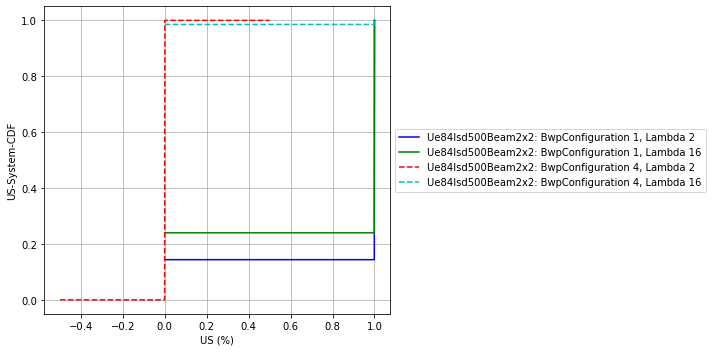

Graph:  SINR-System-CDF
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


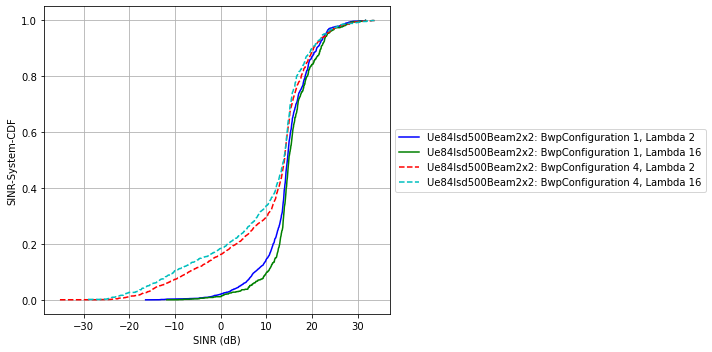

Graph:  Gput-System-CDF
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


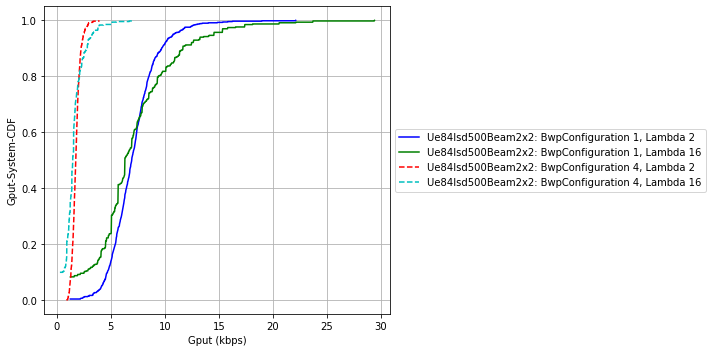

Graph:  Tput-System-CDF
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


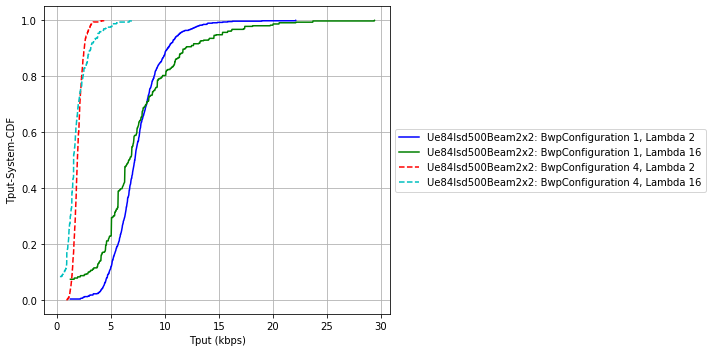

Graph:  MCS-System-CDF
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


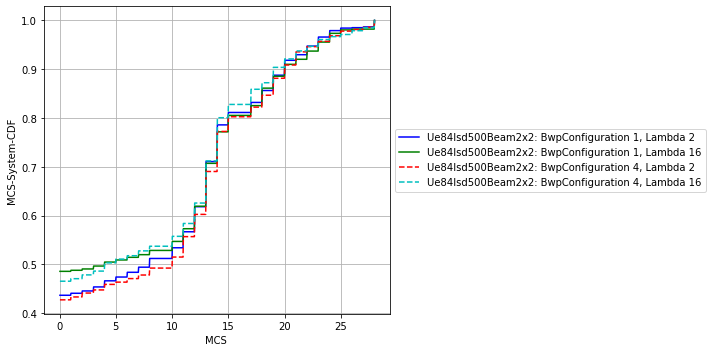

Graph:  TBler-System-CDF
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


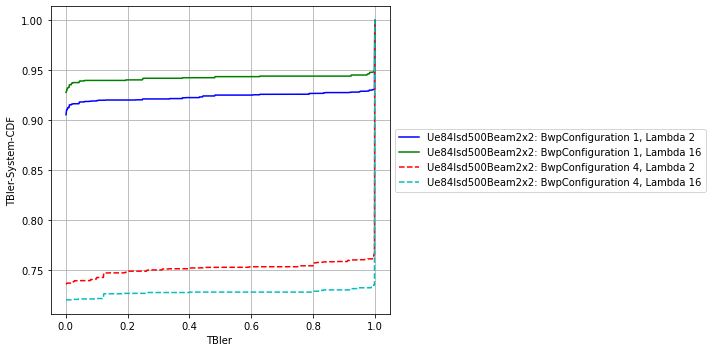

Graph:  Harq-System-CDF
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


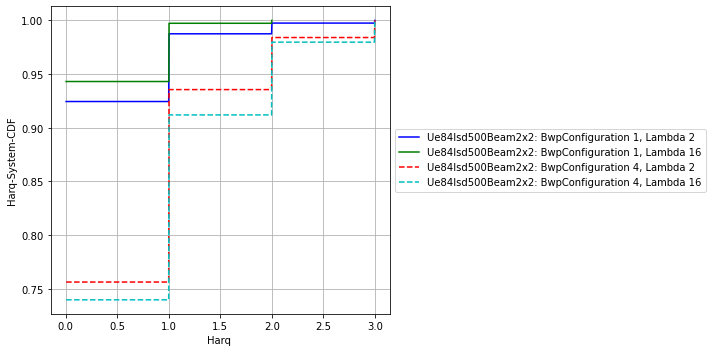

Graph:  US-System
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


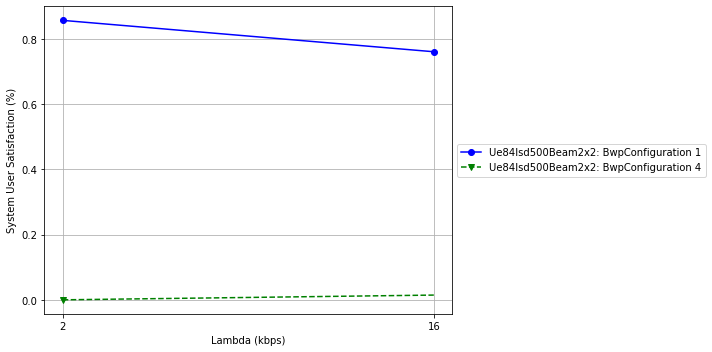

Graph:  SINR-System
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


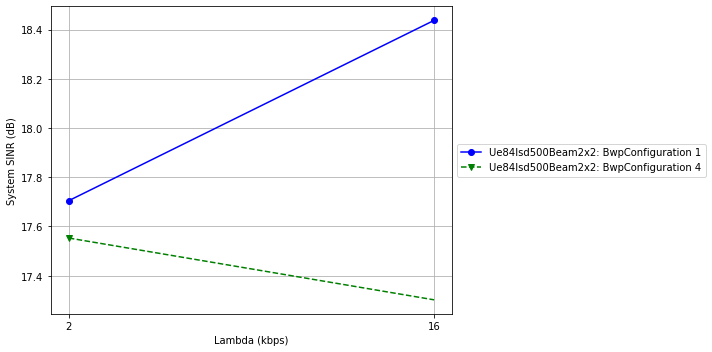

Graph:  Gput-System
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


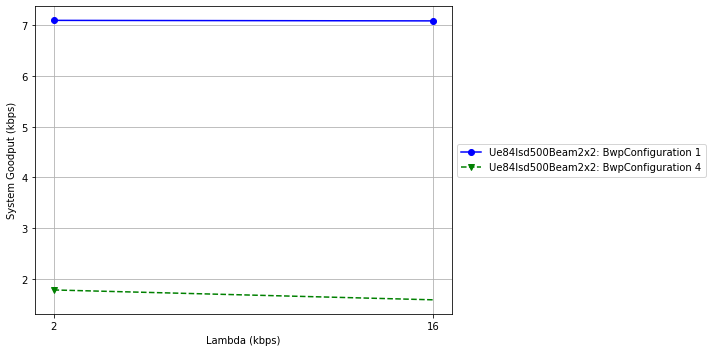

Graph:  Tput-System
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


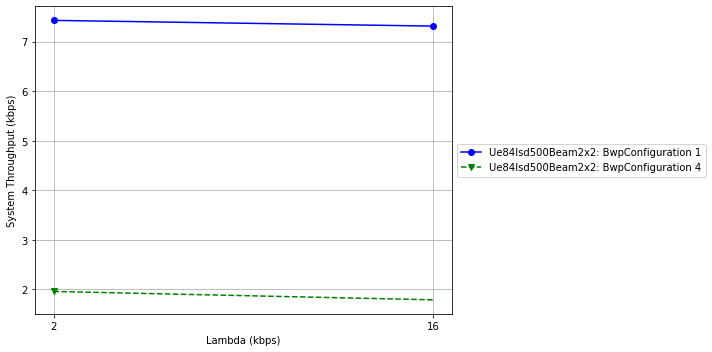

Graph:  MCS-System
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


dfmetric
Empty DataFrame
Columns: []
Index: []


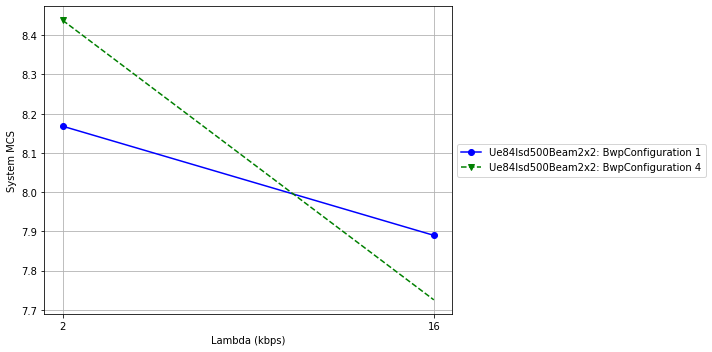

Graph:  TBler-System
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


dfmetric
Empty DataFrame
Columns: []
Index: []


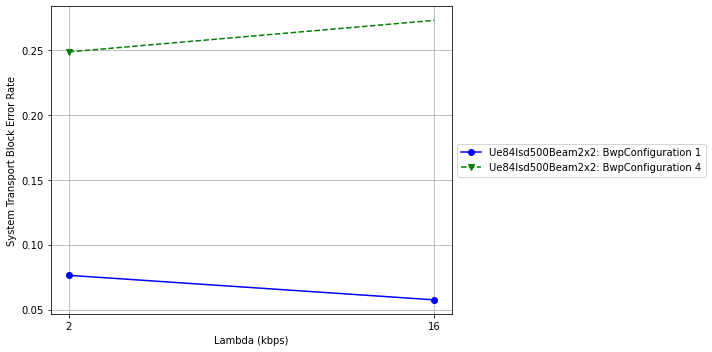

Graph:  Harq-System
Config.Plot:  2 1 2
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []
dfmetric
Empty DataFrame
Columns: []
Index: []


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


dfmetric
Empty DataFrame
Columns: []
Index: []


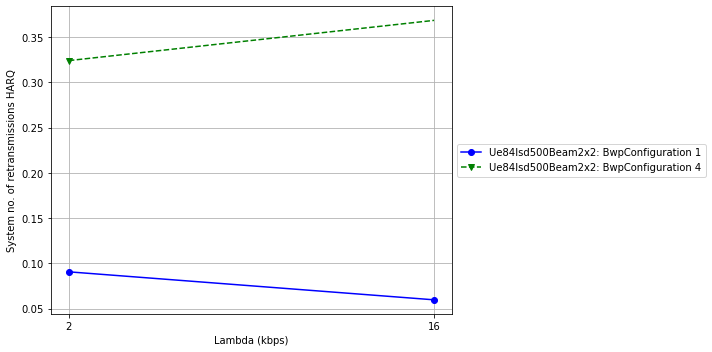

In [45]:
#Linux:
%cd $opath"ScriptsPlot"
%run PlotCampaignScript -s "30" -j "5" -b '0.1' -tiot "5" -plriot "0.9" -l "PHY" -g "System" -t "All" -m "All" -f "NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Isd500_ue84_SlotShannon0_HighLambdaBeam22.yaml" -p $opath"results_cluster_NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Isd500_ue84_SlotShannon0_HighLambdaBeam22_Lambda"

#### PHY - User

/home/ricardo/Repositories/tcc/plots/ScriptsPlot
Campaign to plot: NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Isd500_ue84_SlotShannon0_HighLambdaBeam22
No. of Campaign to plot:  1
Campaign:  ['Lambda']
Kind of Graph:  All
Graph:  US-User-CDF
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


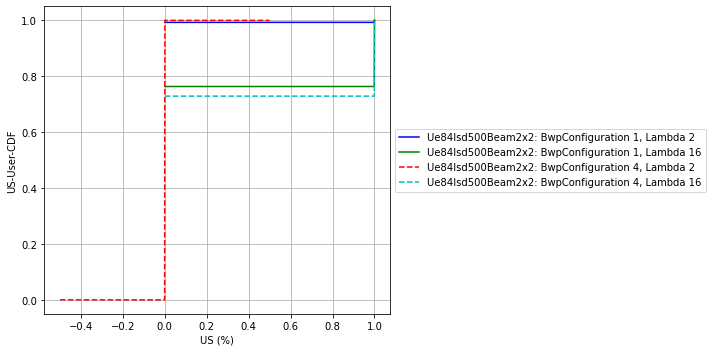

Graph:  SINR-User-CDF
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


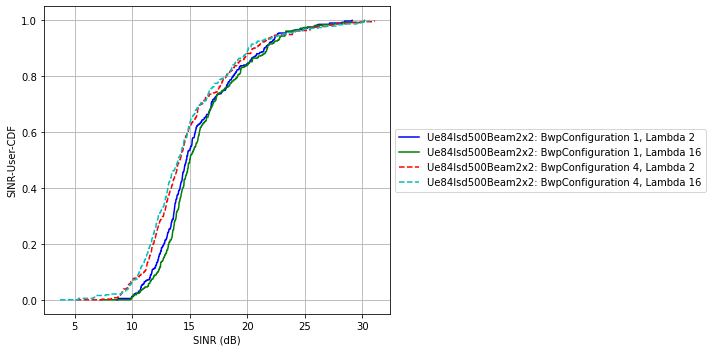

Graph:  Gput-User-CDF
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


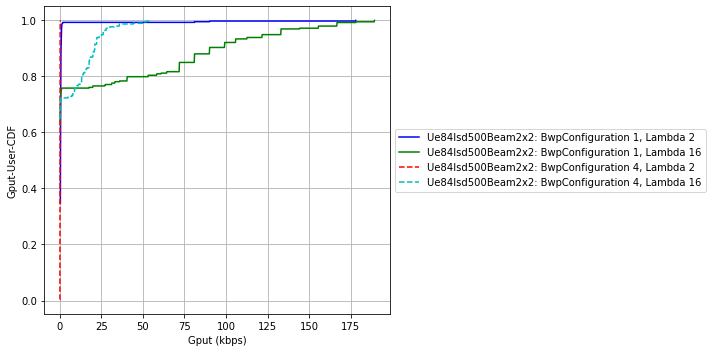

Graph:  Tput-User-CDF
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


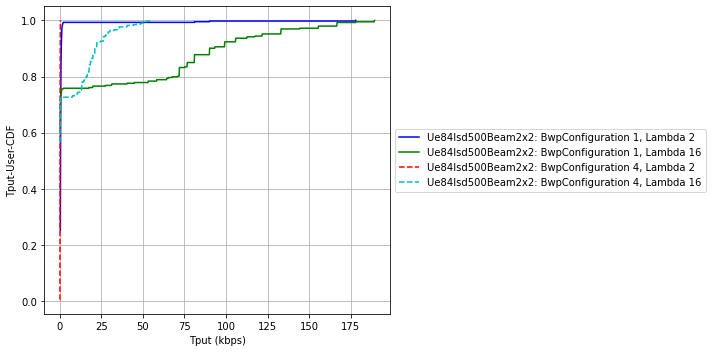

Graph:  MCS-User-CDF
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


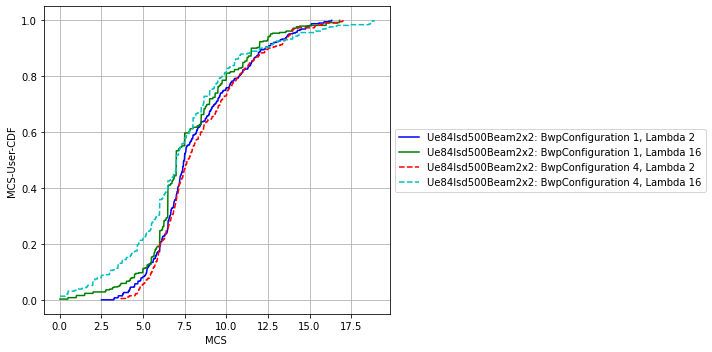

Graph:  TBler-User-CDF
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


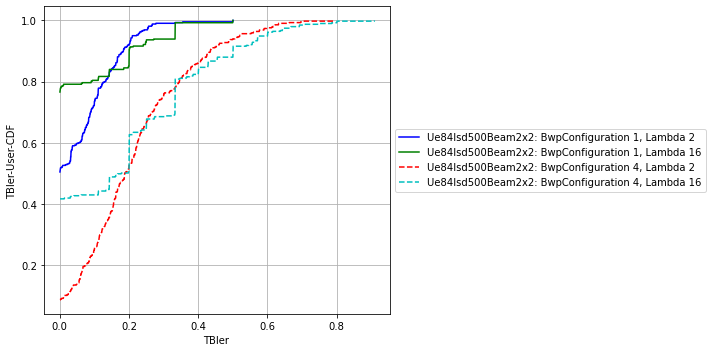

Graph:  Harq-User-CDF
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


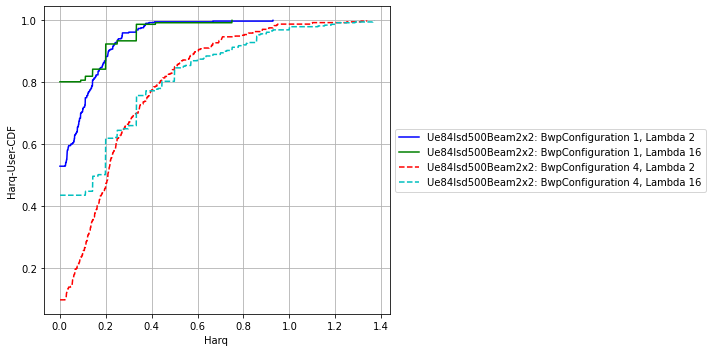

Graph:  US-User
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


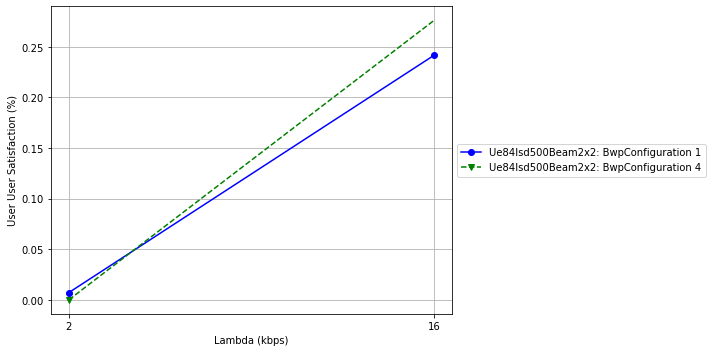

Graph:  SINR-User
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


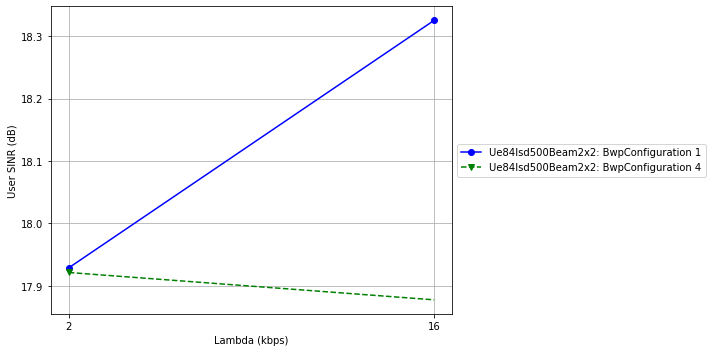

Graph:  Gput-User
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


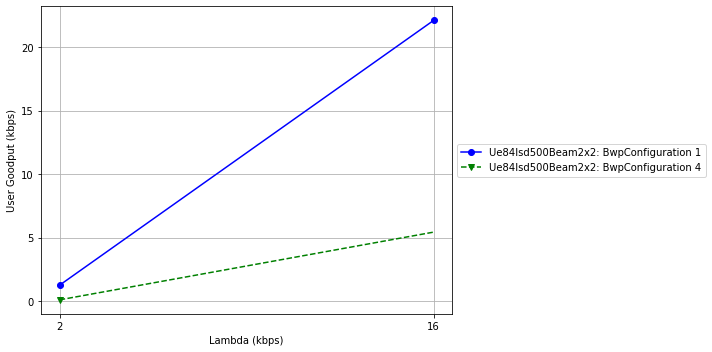

Graph:  Tput-User
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


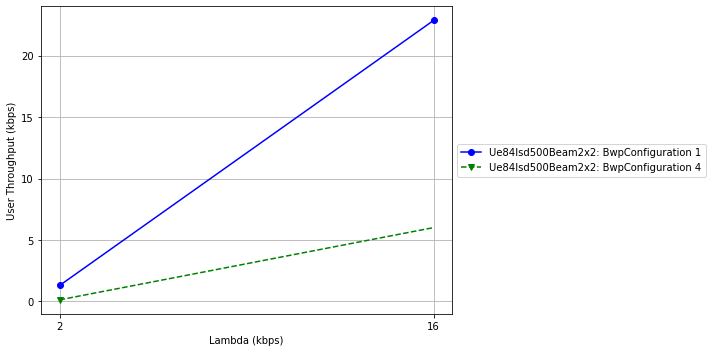

Graph:  MCS-User
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


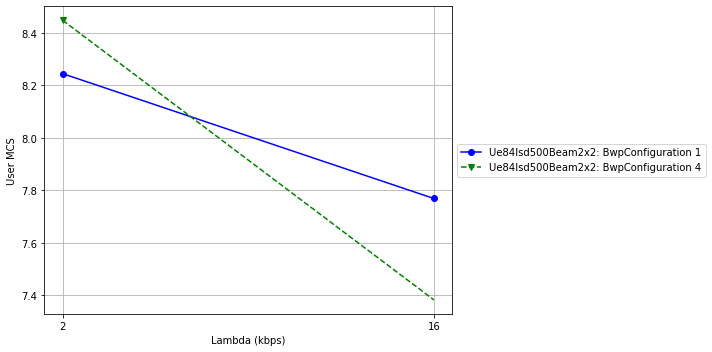

Graph:  TBler-User
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


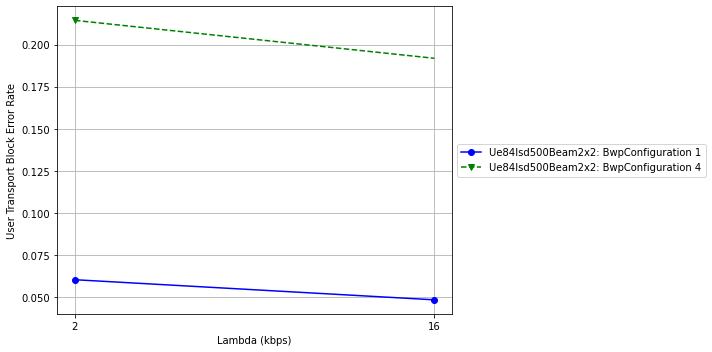

Graph:  Harq-User
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


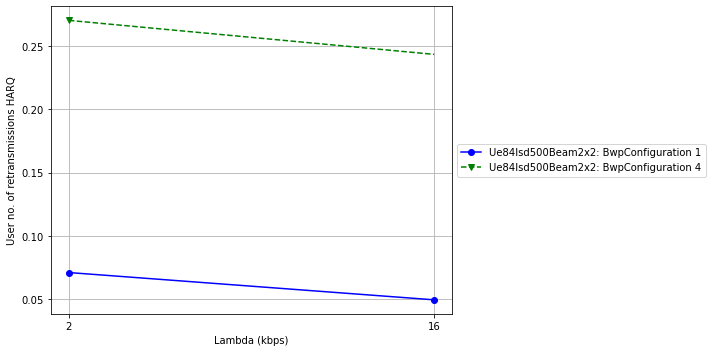

In [37]:
#Linux:
%cd $opath"ScriptsPlot"
%run PlotCampaignScript -s "30" -j "5" -b '0.1' -tiot "5" -plriot "0.9" -l "PHY" -g "User" -t "All" -m "All" -f "NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Isd500_ue84_SlotShannon0_HighLambdaBeam22.yaml" -p $opath"results_cluster_NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Isd500_ue84_SlotShannon0_HighLambdaBeam22_Lambda"

#### IP

/home/ricardo/Repositories/tcc/plots/ScriptsPlot
Campaign to plot: NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Isd500_ue84_SlotShannon0_HighLambdaBeam22
No. of Campaign to plot:  1
Campaign:  ['Lambda']
Kind of Graph:  All
Graph:  Tput-IP
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


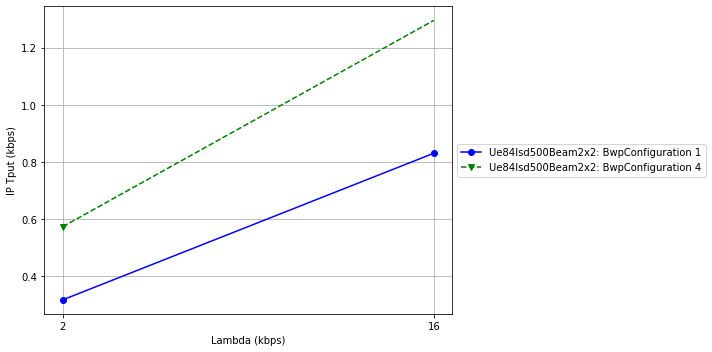

Graph:  Delay-IP
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


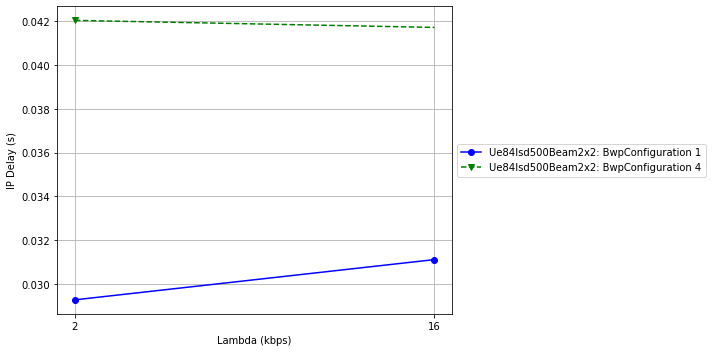

Graph:  TxOffered-IP
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


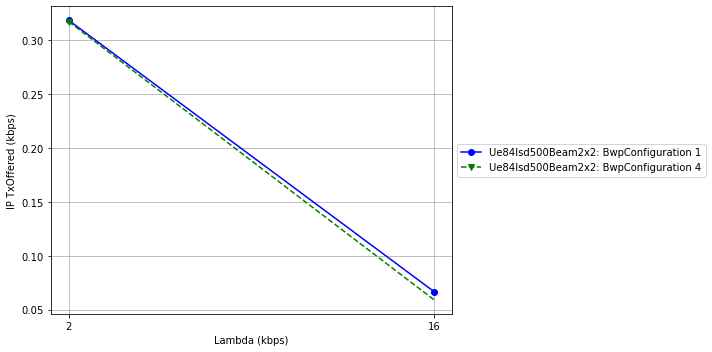

Graph:  PLR-IP
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


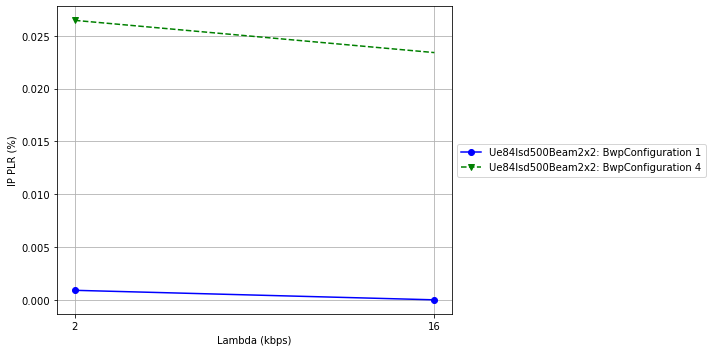

Graph:  US-IP
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


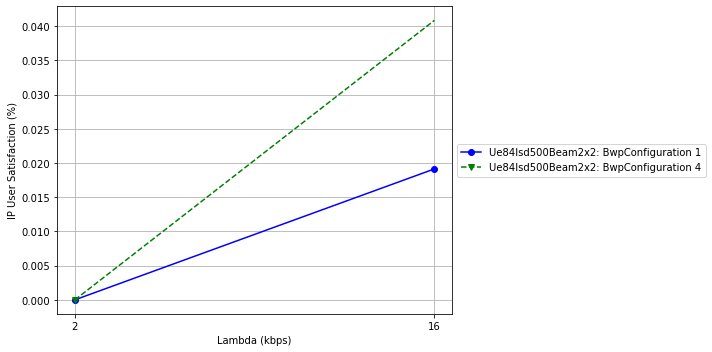

Graph:  Tput-IP-CDF
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


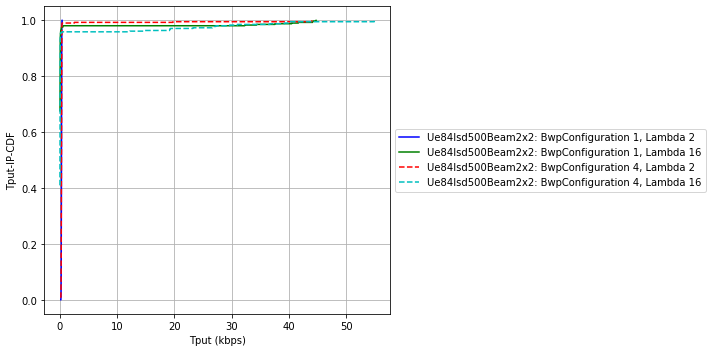

Graph:  Delay-IP-CDF
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


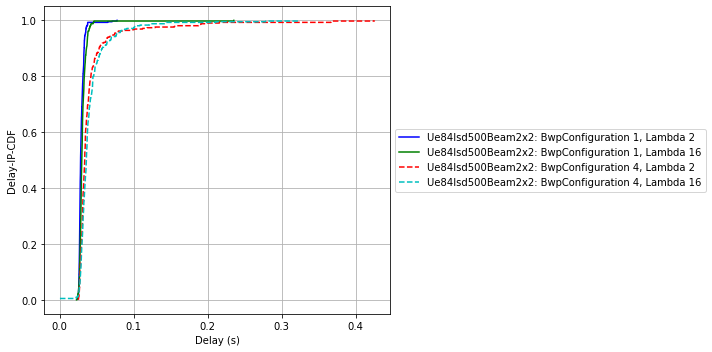

Graph:  TxOffered-IP-CDF
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


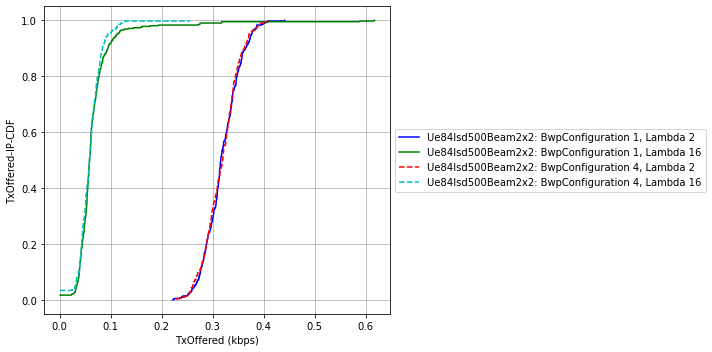

Graph:  PLR-IP-CDF
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


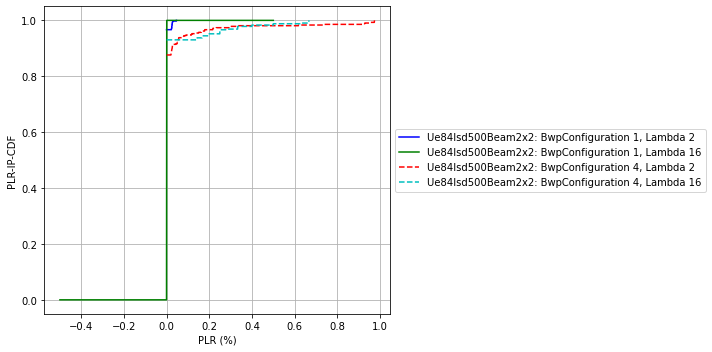

Graph:  US-IP-CDF
Config.Plot:  2 1 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


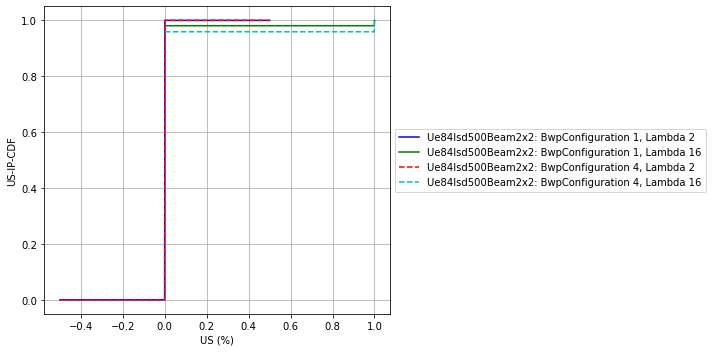

In [36]:
#Linux:
%cd $opath"ScriptsPlot"
%run PlotCampaignScript -s "30" -j "5" -b '0.1' -tiot "5" -plriot "0.9" -l "IP" -g "User" -t "All" -m "All" -f "NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Isd500_ue84_SlotShannon0_HighLambdaBeam22.yaml" -p $opath"results_cluster_NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Isd500_ue84_SlotShannon0_HighLambdaBeam22_Lambda"